In [3]:
#install de pacotes
!pip install inflection
!pip install boruta
!pip install xgboost

     ---------------------------------------- 89.1/89.1 MB 8.5 MB/s eta 0:00:00


In [1]:
#imports

import math
import numpy as np
import pandas as pd
import inflection
import datetime
import seaborn as sns
import xgboost as xgb
import random
import pickle
import requests
import json

from flask                 import Flask, request, Response
from boruta                import BorutaPy
from scipy                 import stats
from tabulate              import tabulate
from matplotlib            import pyplot as plt
from IPython.display       import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

## Helper Functions

In [2]:
# Cálculo de correlação de Variáveis usando v de Cramer
def cramer_v(x,y):
    # Cálculo de tabela de contingencia. Método "crosstab" faz todas as possíveis combinações entre as variáveis.
    cm = pd.crosstab(x,y).values
    n = cm.sum()# Soma todos os valores.
    r,k = cm.shape
    # Cálculo do Chi2. Usamos um método chamado "contingency" que vem da biblioteca "scipy/stats" 
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    # Corrigindo Bias
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)    
    # Fórmula do v de Cramer (Raiz quadrada e divisão de 2 termos. No 1º tem um (chi2/n) dividido pelo 2º termo que é o menor valor entre a coluna -1 (k-1) e linha -1 (r-1))
    return np.sqrt((chi2corr/n) / (min(kcorr-1,rcorr-1)))

# ========================================================================
# Função que calcula as métricas de erros do modelo. 
def ml_error(model_name, y, yhat):# A função recebe o nome do modelo, os valores reais e os valores preditos.
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

# ========================================================================

# Função de cross validation. 
    # x_training == dados de treino
    # kfold == Quantidade de iterações
    # model_name == Nome do modelo testado
    # model == Instância do modelo
    # verbose == Não 'printa' na tela o algoritmo fazendo as iterações.
    # Retorna um dataframe com nome do modelo e a média k de cada erro (MAE, MAPE, RMSE) somada a 1 desvio padrão.
    
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # Cross Validation
        ## Selecionando as datas de início e fim para o treinamento do modelo.
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # Filtrando Dataset - Datas menores que 'validation_start_date' serão dados pra treino. As maiores será para o validation.
        training = x_training[x_training['date']< validation_start_date]
        validation = x_training[(x_training['date']>= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # Treino e Validação do dataset
        ## Treino
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        ## Validação
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # Modelo
        m = model.fit(xtraining, ytraining)

        # Predição
        yhat = m.predict(xvalidation)

        # Performance
        m_result = ml_error(model_name, np.expm1 (yvalidation), np.expm1(yhat))

        # Armazenar o desempenho de cada iteração do kfold
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    # Criação de tabela com o cálculo do Cross Validation.
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str), 
                          'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index =[0])

# ========================================================================
# Não mostrar mensagens de Warning
pd.options.mode.chained_assignment = None

In [3]:
#Carregando Dados


df_sales_raw = pd.read_csv('train.csv', low_memory=False)
df_store_raw = pd.read_csv('store.csv', low_memory=False)

# join
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
#Descrição dos Dados

df1 = df_raw.copy()

In [5]:
#Renomeando colunas

# Nomes das colunas originais. (Sem espaço entre as palavras do nome e com letras maiúsculas e minúsculas = camelCase)
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',               'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

#Substitui o camelCase por snake_case 
cols_new = list(map(lambda x: inflection.underscore(x), cols_old))
df1.columns = cols_new

In [6]:
#Dimensão dos Dados

print('Número de Linhas: {}'.format(df1.shape[0]))
print('Número de Colunas: {}'.format(df1.shape[1]))

Número de Linhas: 1017209
Número de Colunas: 18


In [7]:
#Tipo dos Dados

df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [8]:
#checando NA

df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [9]:
#Preenchendo valores NA

#Preenchendo valores faltantes de competition_distance. Neste caso, foi decidido inserir um valor outlier.
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#Preenchendo valores faltantes de competition_open_since_month. Neste caso, foi usado o mês da coluna date.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#Preenchendo valores faltantes de competition_open_since_year. Neste caso, foi usado o ano da coluna date.
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                      
#Preenchendo valores faltantes de promo2_since_week. Neste caso, foi calculado o week da coluna date.        
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#Preenchendo valores faltantes de promo2_since_year. Neste caso, foi calculado o year da coluna date.
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#Preenchendo valores faltantes de promo_interval. Neste caso, foi criado um dicionário para substituir o números pelos meses do ano.
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# Completa com 0 os valores faltantes.
df1['promo_interval'].fillna(0, inplace=True)

# Conversão do mês numérico para a abreviação.
df1['month_map'] = df1['date'].dt.month.map(month_map)

# Cálculo para saber quais lojas estão em período de promoção. 1 para sim e 0 para não.
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [10]:
df1.isna().sum() 

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [11]:
# Alterando os tipos de dados
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## Estatística Descritiva

In [13]:
# Separando os atributos entre numéricos e categóricos
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [14]:
#Atributos Numéricos

# Tendência central - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenando
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median','std','skew','kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.904152,1.625796


## Atributos categóricos

In [15]:
# Visualizando valores únicos.
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

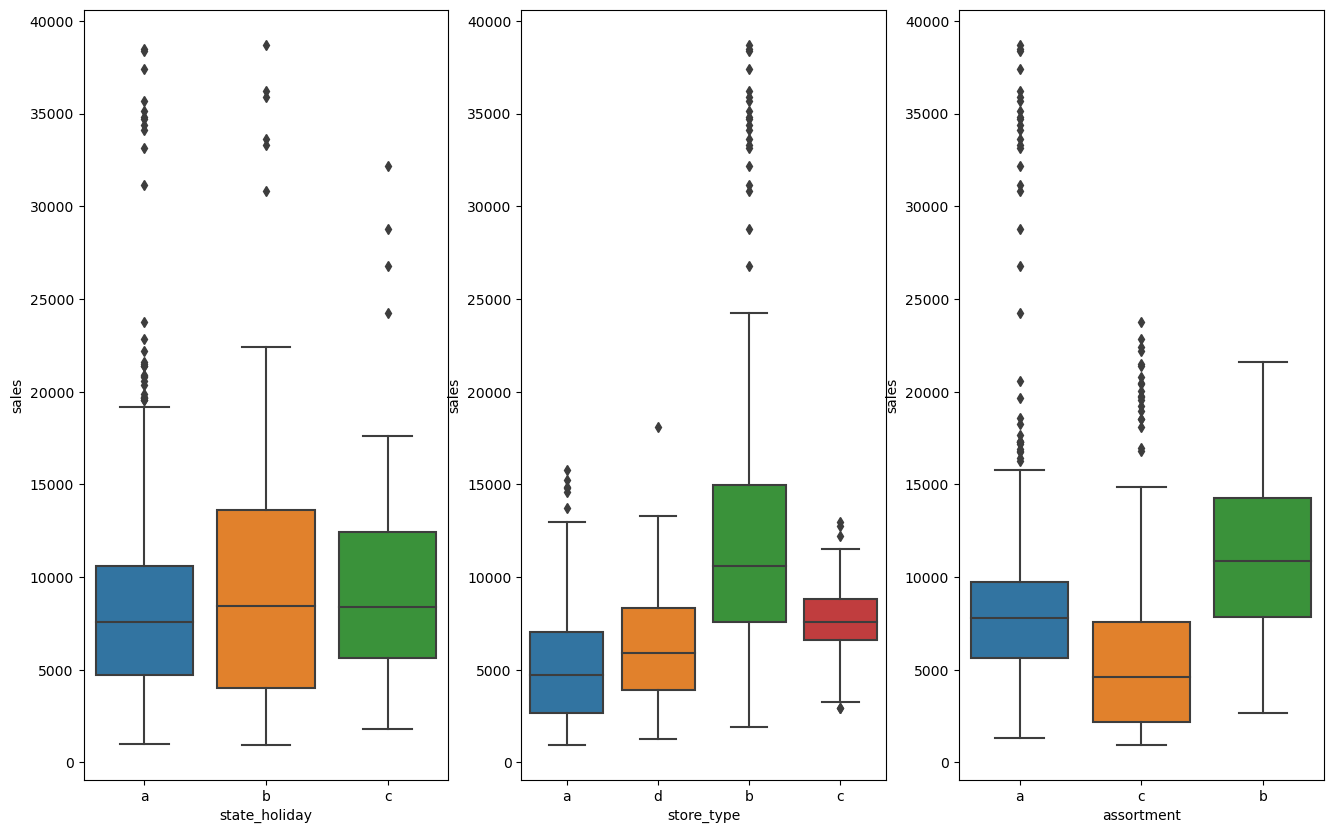

In [16]:
# Criando gráficos Boxplot
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]

plt.figure(figsize=(16,10))
plt.subplot (1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1);

plt.subplot (1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1);

plt.subplot (1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1);

## Feature Engineering

In [17]:

df2 = df1.copy()

### **Mapa de hipóteses**

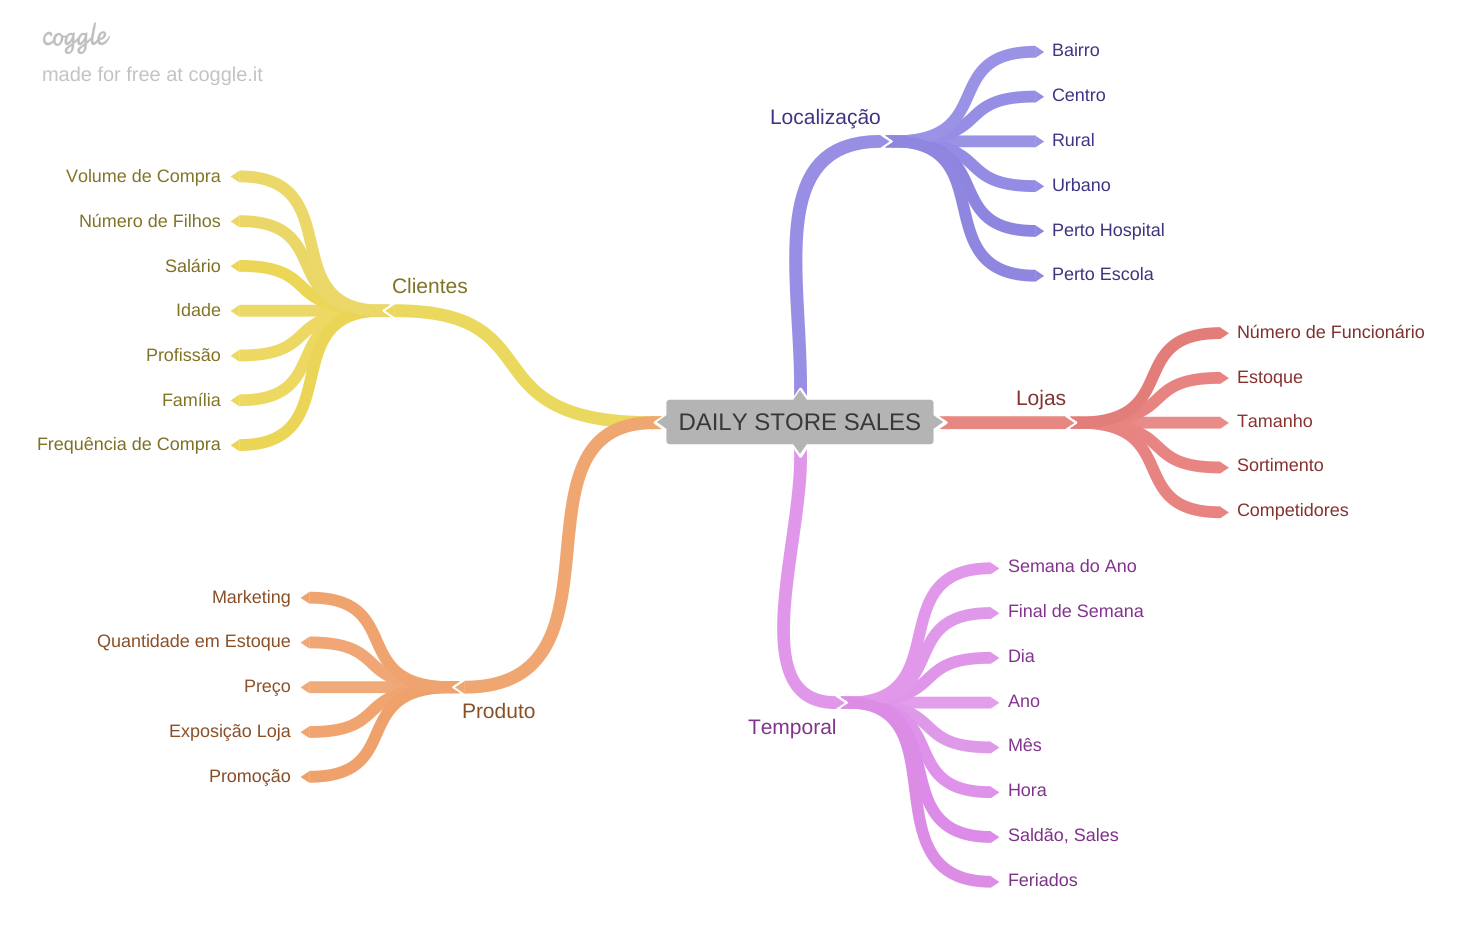

In [18]:
Image ('mapa_hipoteses.png')

## **Criação de hipótese**

###  Hipótese da loja
1. Lojas com maior sortimento deveriam vender mais.

2. Lojas com competidores mais próximos deveriam vender menos.

3. Lojas com competidores a mais tempo deveriam vender mais.

### Hipótese do produto
1. Lojas com promoções ativas por mais tempo deveriam vender mais.

2. Lojas com mais promoções consecutivas deveriam vender mais.

### Hipótese de tempo
1. Lojas abertas durante o feriado do Natal deveriam vender mais.

2. Lojas deveriam vender mais ao longo dos anos.

3. Lojas deveriam vender mais no segundo sementre do ano.

4. Lojas deveriam vender mais depois do dia 10 de cada mês.

5. Lojas deveriam vender menos aos finais de semana.

6. Lojas deveriam vender menos durante os feriados escolares.

### Lista Final de Hipóteses
1. Lojas com maior sortimento deveriam vender mais.

2. Lojas com competidores mais próximos deveriam vender menos.

3. Lojas com competidores a mais tempo deveriam vender mais.

4. Lojas com promoções ativas por mais tempo deveriam vender mais.

5. Lojas com mais promoções consecutivas deveriam vender mais.

6. Lojas abertas durante o feriado do Natal deveriam vender mais.

7. Lojas deveriam vender mais ao longo dos anos.

8. Lojas deveriam vender mais no segundo sementre do ano.

9. Lojas deveriam vender mais depois do dia 10 de cada mês.

10. Lojas deveriam vender menos aos finais de semana.

11. Lojas deveriam vender menos durante os feriados escolares.

## Feature Engineering

In [18]:
# Criando a coluna Year
df2['year'] = df2['date'].dt.year

# Criando a coluna Month
df2['month'] = df2['date'].dt.month

# Criando a coluna Day
df2['day'] = df2['date'].dt.day

# Criando a coluna Week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Criando a coluna Year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Criando a coluna Competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply (lambda x: x.days).astype(int)

# Criando a coluna Promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w')-datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# Criando a coluna Assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# Criando a coluna State holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [19]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## **Filtrando Variáveis**

In [20]:
df3 = df2.copy()

In [21]:
#Filtrando linhas

# Selecionando apenas as lojas que estão em funcionamento.
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

In [22]:
#Filtrando Colunas

# Escluindo colunas desnecessárias
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

## EDA (Exploration Data Analysis)

In [23]:
df4 = df3.copy()

sns.set(rc={'figure.figsize':(13,8)})

## Análise Univariada

C:\Users\Estúdio\AppData\Local\Temp\ipykernel_81404\2441844441.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales'], kde=True);


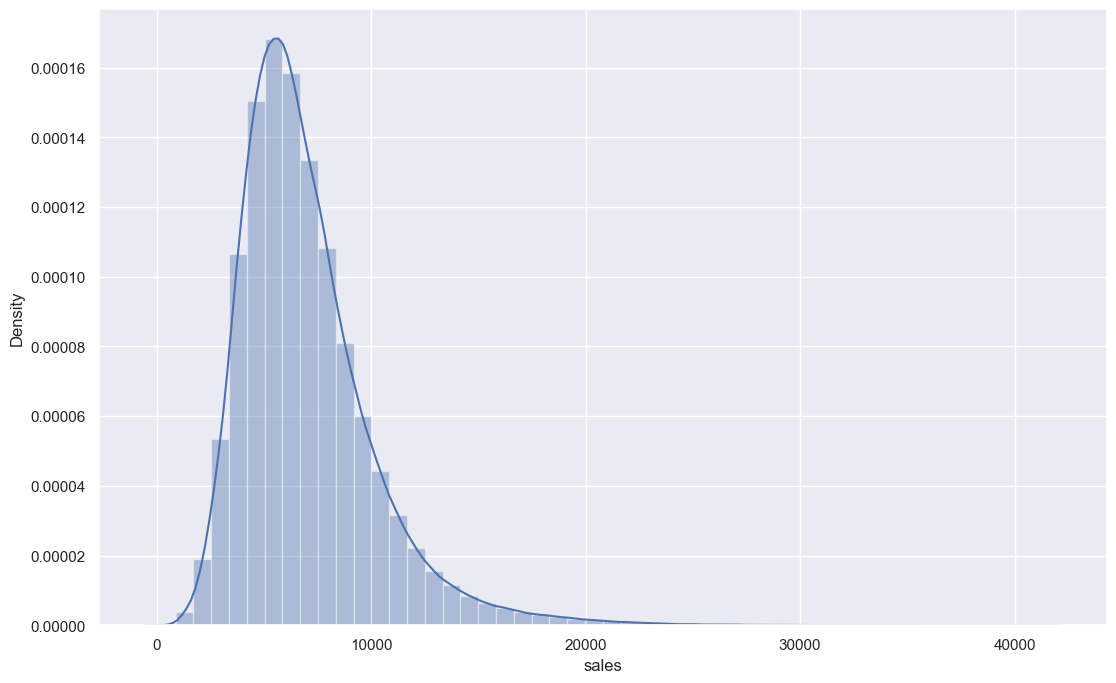

In [24]:
#Variável Resposta 

sns.distplot(df4['sales'], kde=True);

## variável numérica

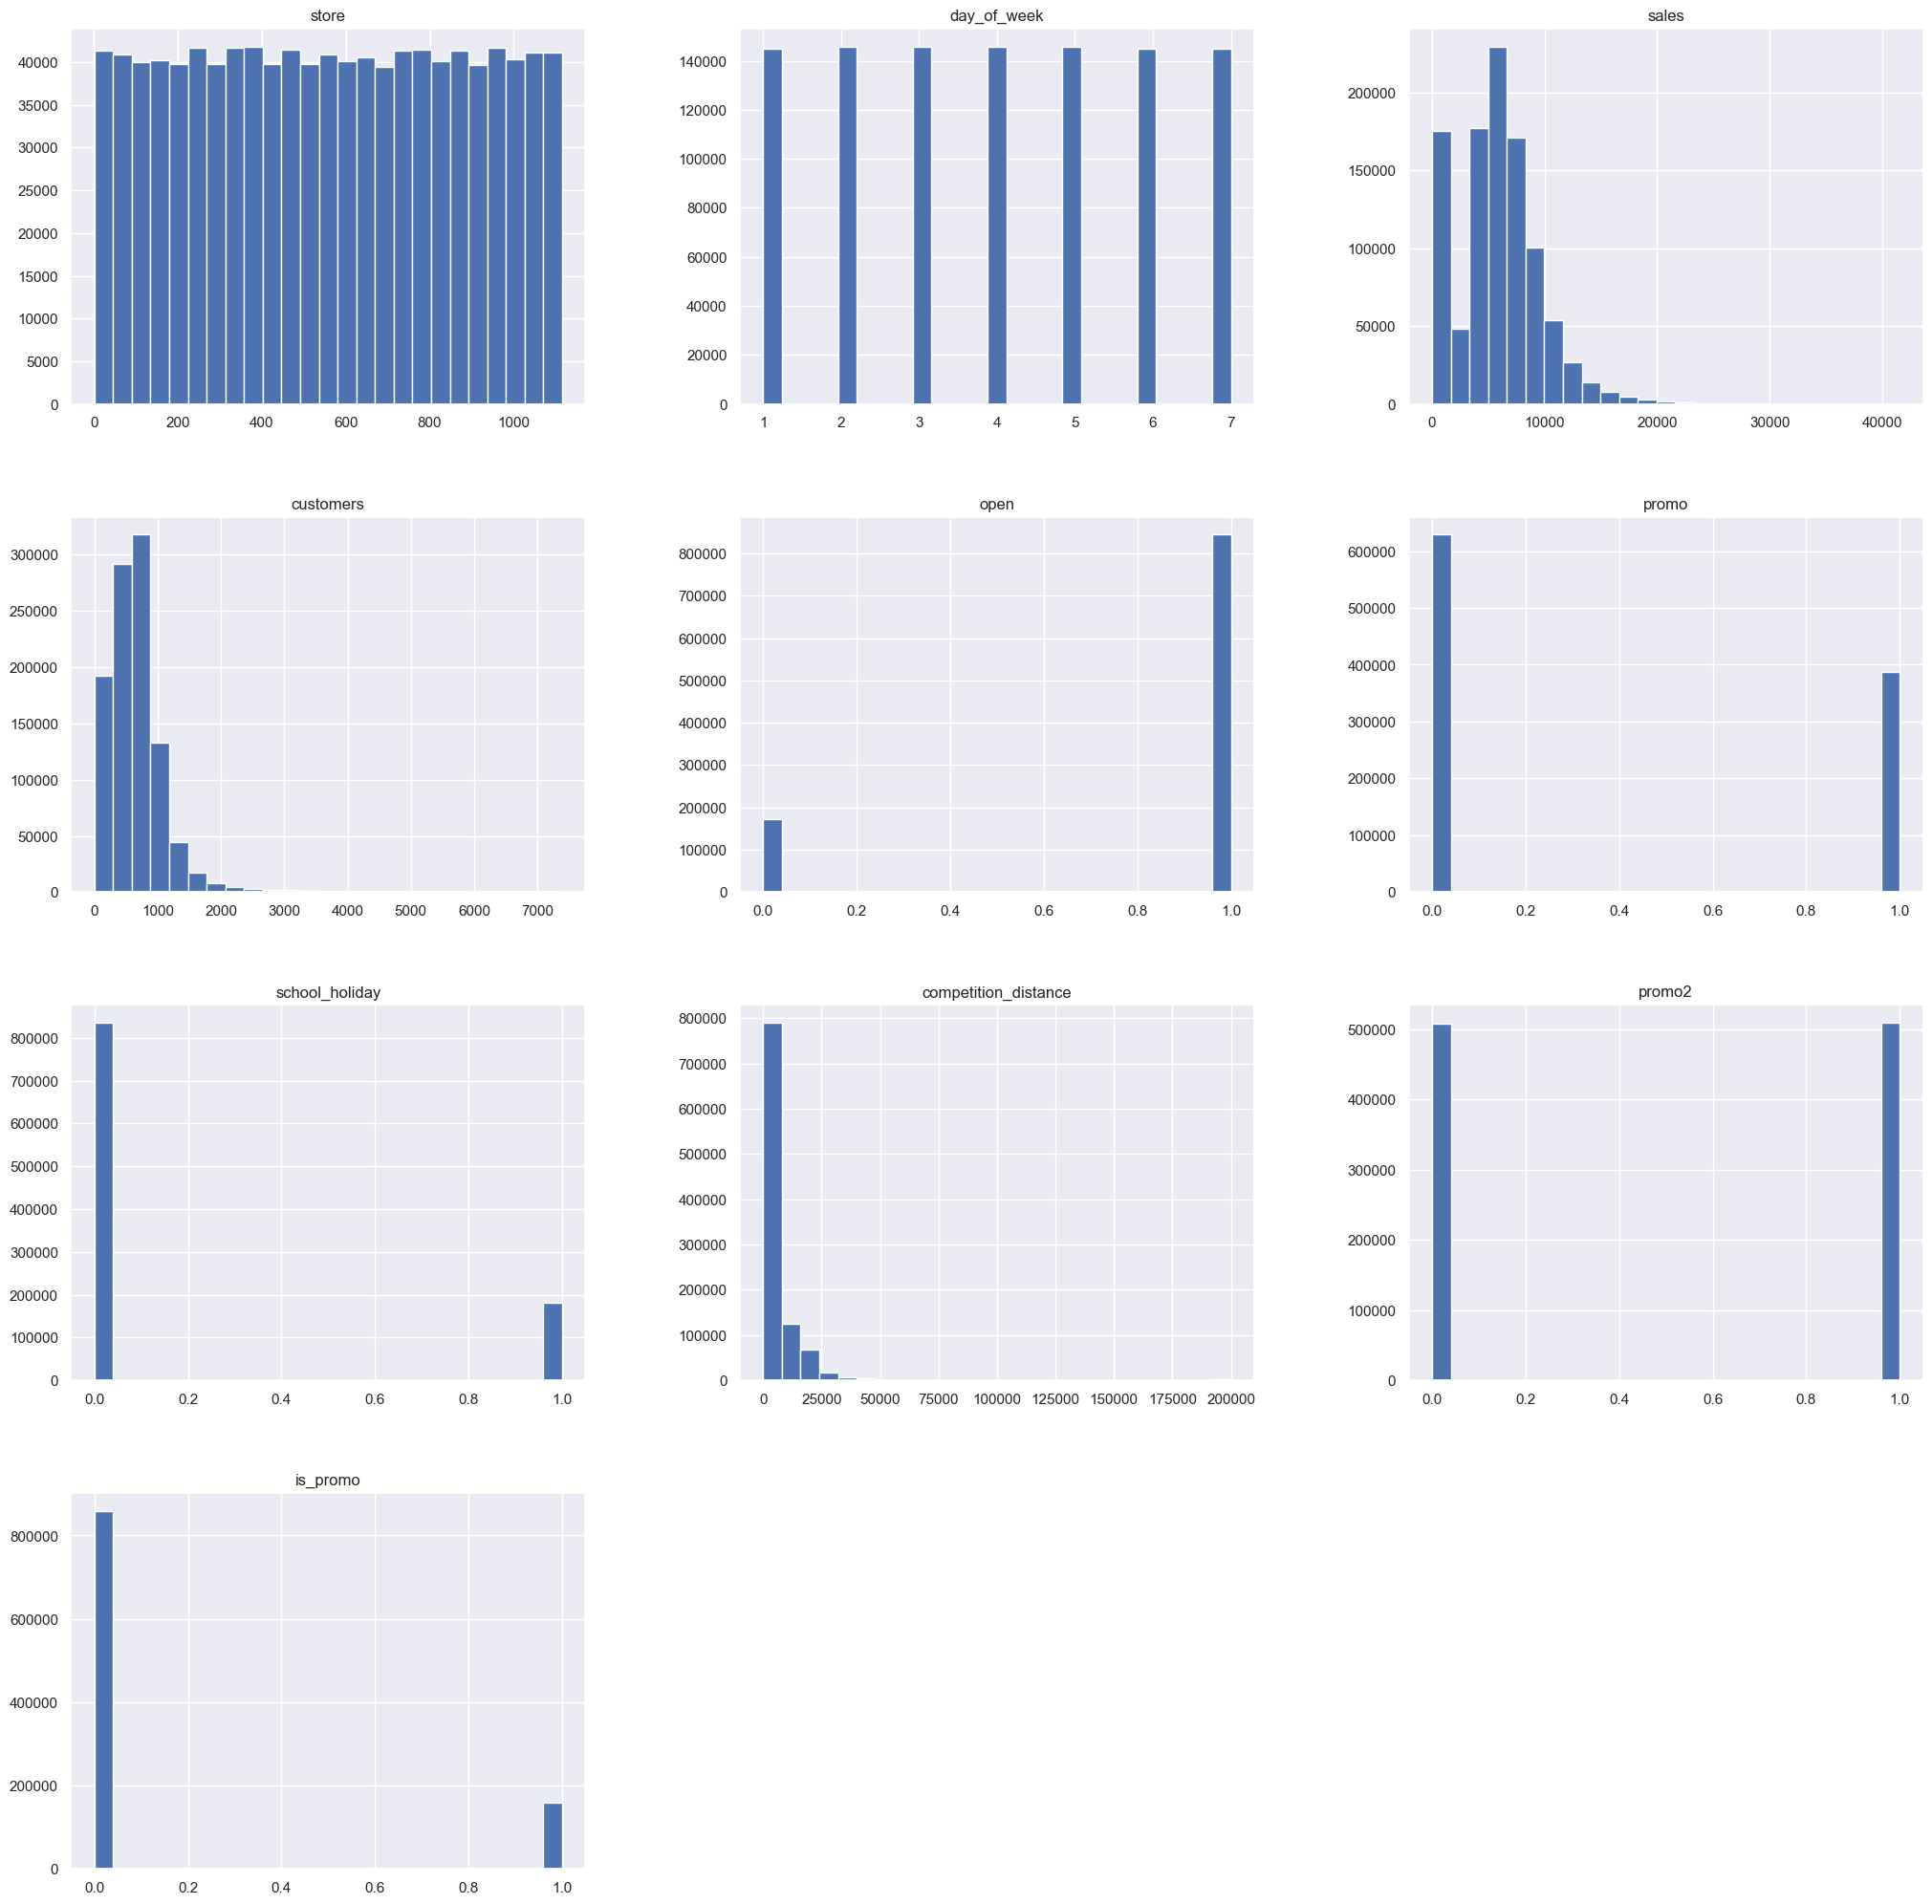

In [25]:
num_attributes.hist(bins=25, figsize=(25,25));

### **Variável categórica**

C:\Users\Estúdio\AppData\Local\Temp\ipykernel_81404\3548235861.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
C:\Users\Estúdio\AppData\Local\Temp\ipykernel_81404\3548235861.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
C:\Users\Estúdio\AppData\Local\Temp\ipykernel_81404\3548235861.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
C:\Users\Estúdio\

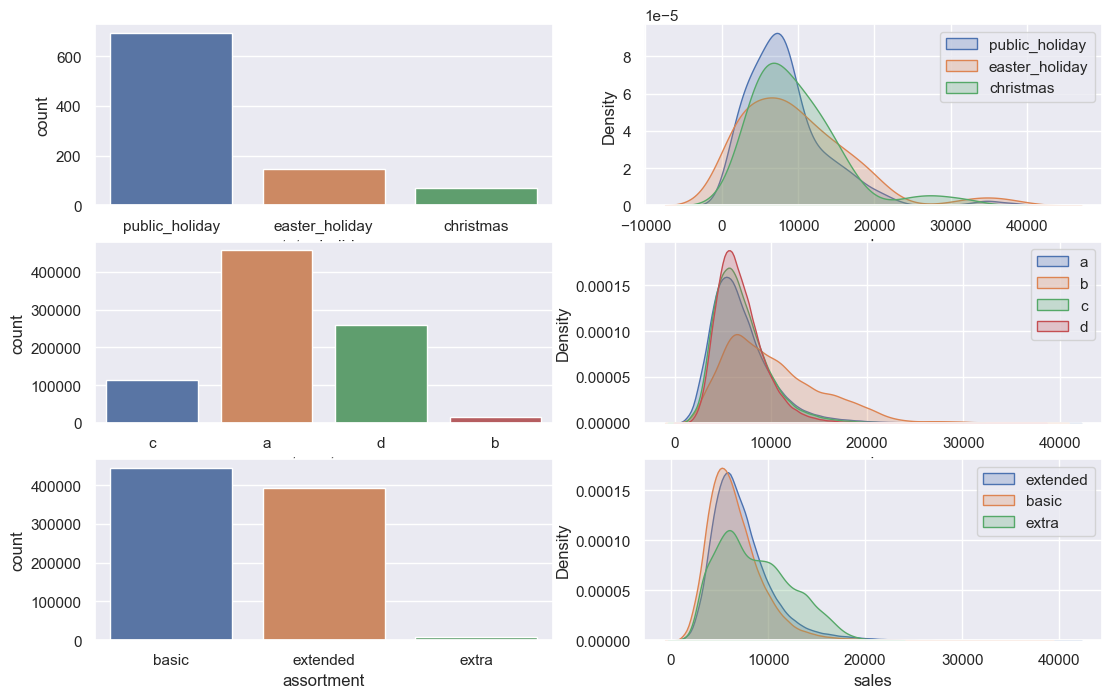

In [26]:
# State_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
plt.legend(labels=['public_holiday','easter_holiday','christmas'])

# Store_type
plt.subplot(3,2,3)
sns.countplot(x=df4['store_type']);

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend(labels=['a','b','c','d'])

# Assortment
plt.subplot(3,2,5)
sns.countplot(x=df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.legend(labels=['extended','basic','extra']);

### **Análise Bivariada**

### H1. Lojas com maior sortimento deveriam vender mais.

*VERDADEIRO* Lojas com MAIOR SORTIMENTO vendem MAIS.

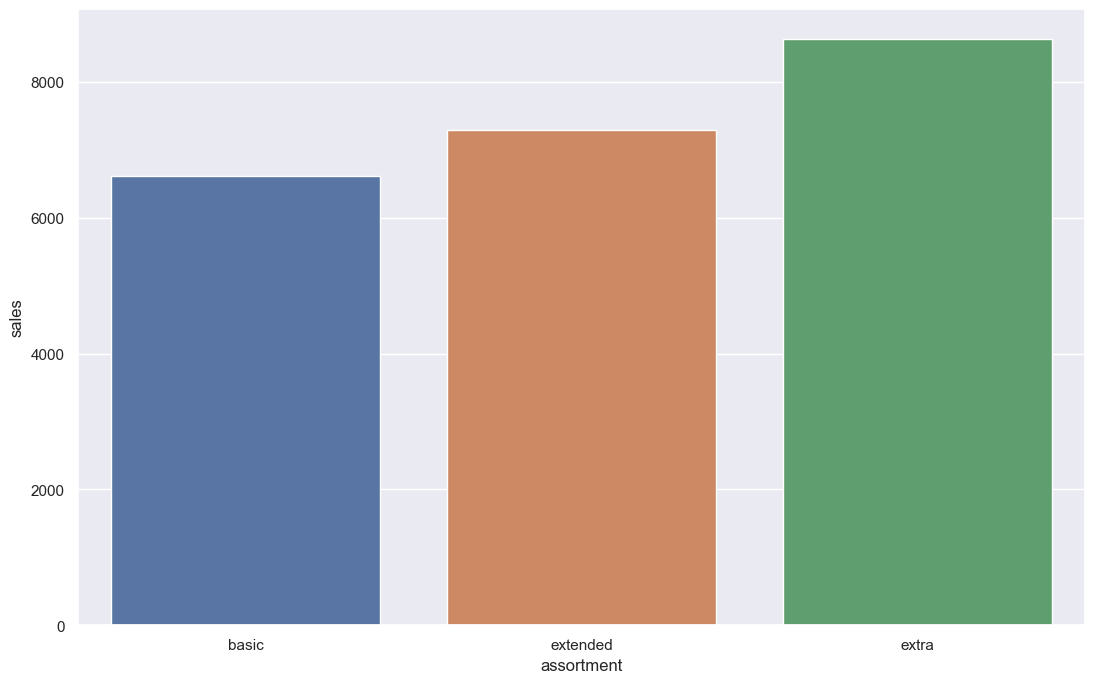

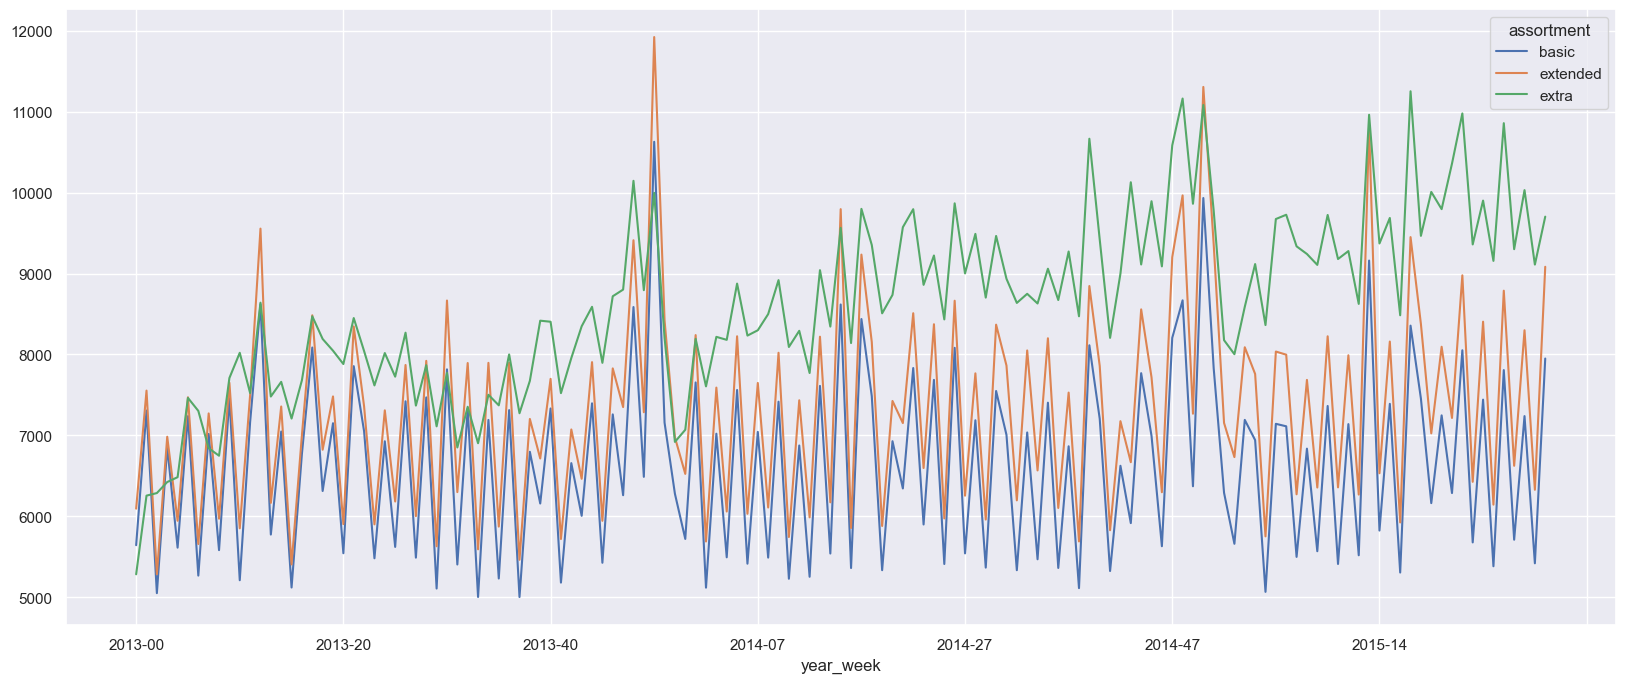

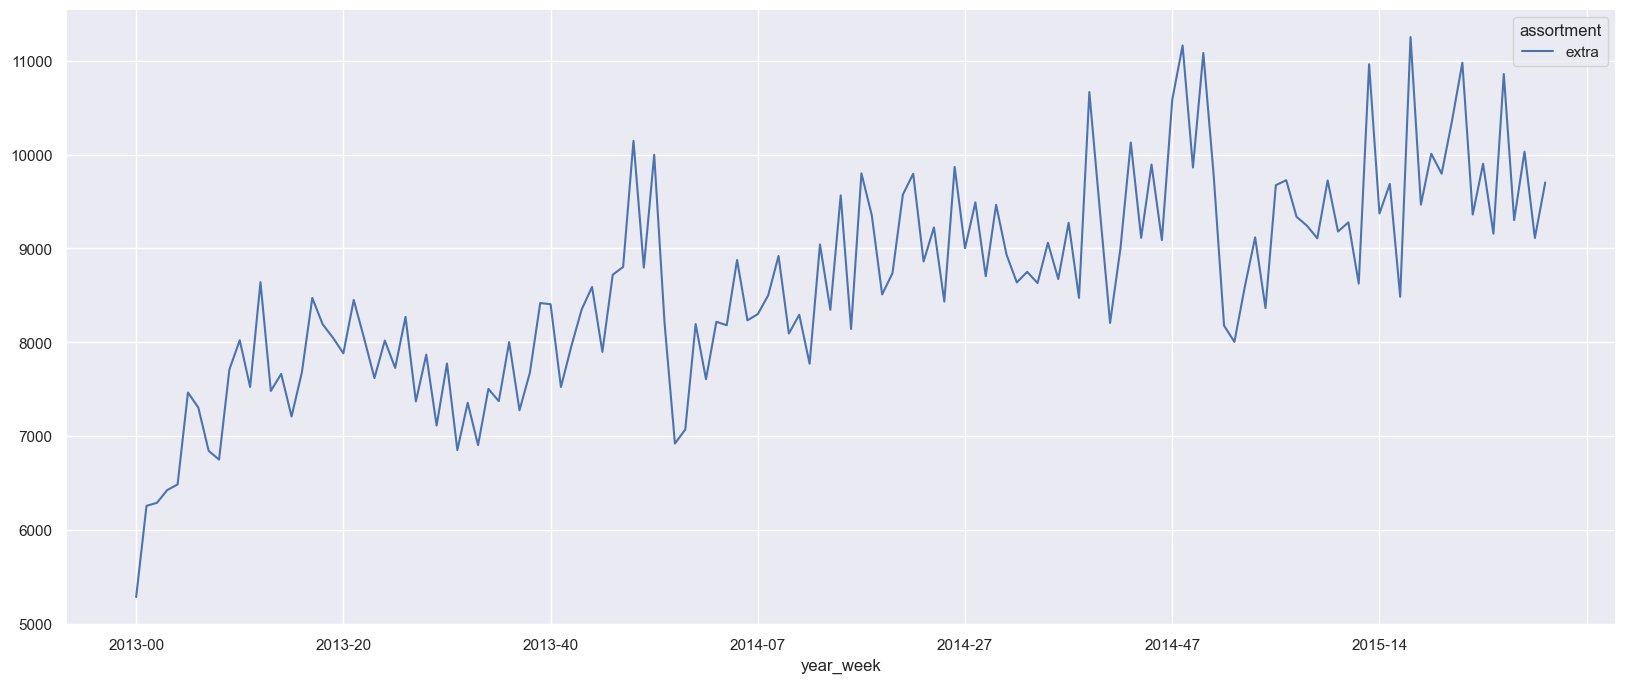

In [27]:
# Quantidade de vendas por tipo de assortment
aux1 = df4[['assortment','sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

# Quantidade de vendas por assortment por semanas do ano
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).mean().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(20,8));

# Plotagem somente do tipo 'extra' de assortment
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index= 'year_week', columns= 'assortment', values='sales').plot(figsize=(20,8));

### H2. Lojas com competidores mais próximos deveriam vender menos.

*FALSA* Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

C:\Users\Estúdio\AppData\Local\Temp\ipykernel_81404\801082247.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  x = sns.heatmap(aux1.corr(method='pearson'), annot=True);


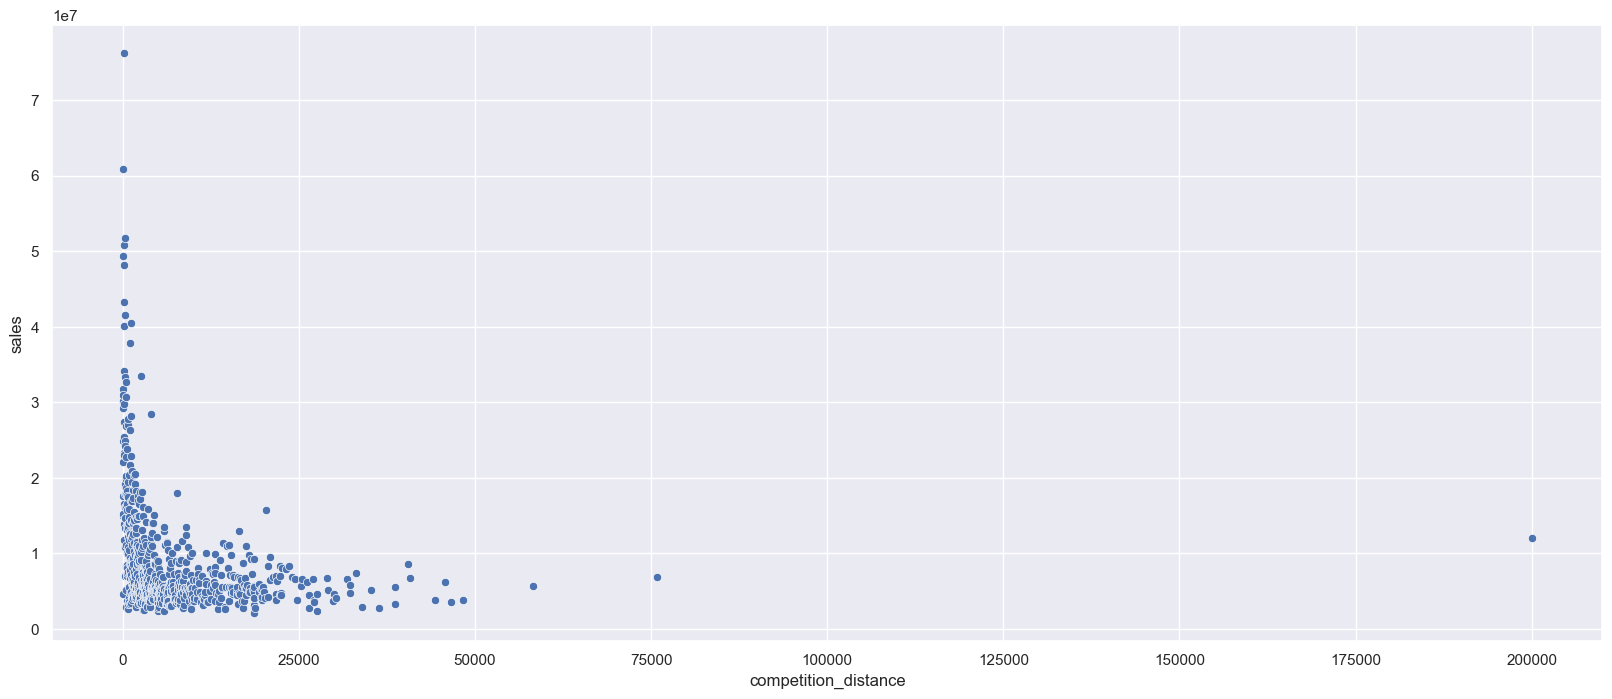

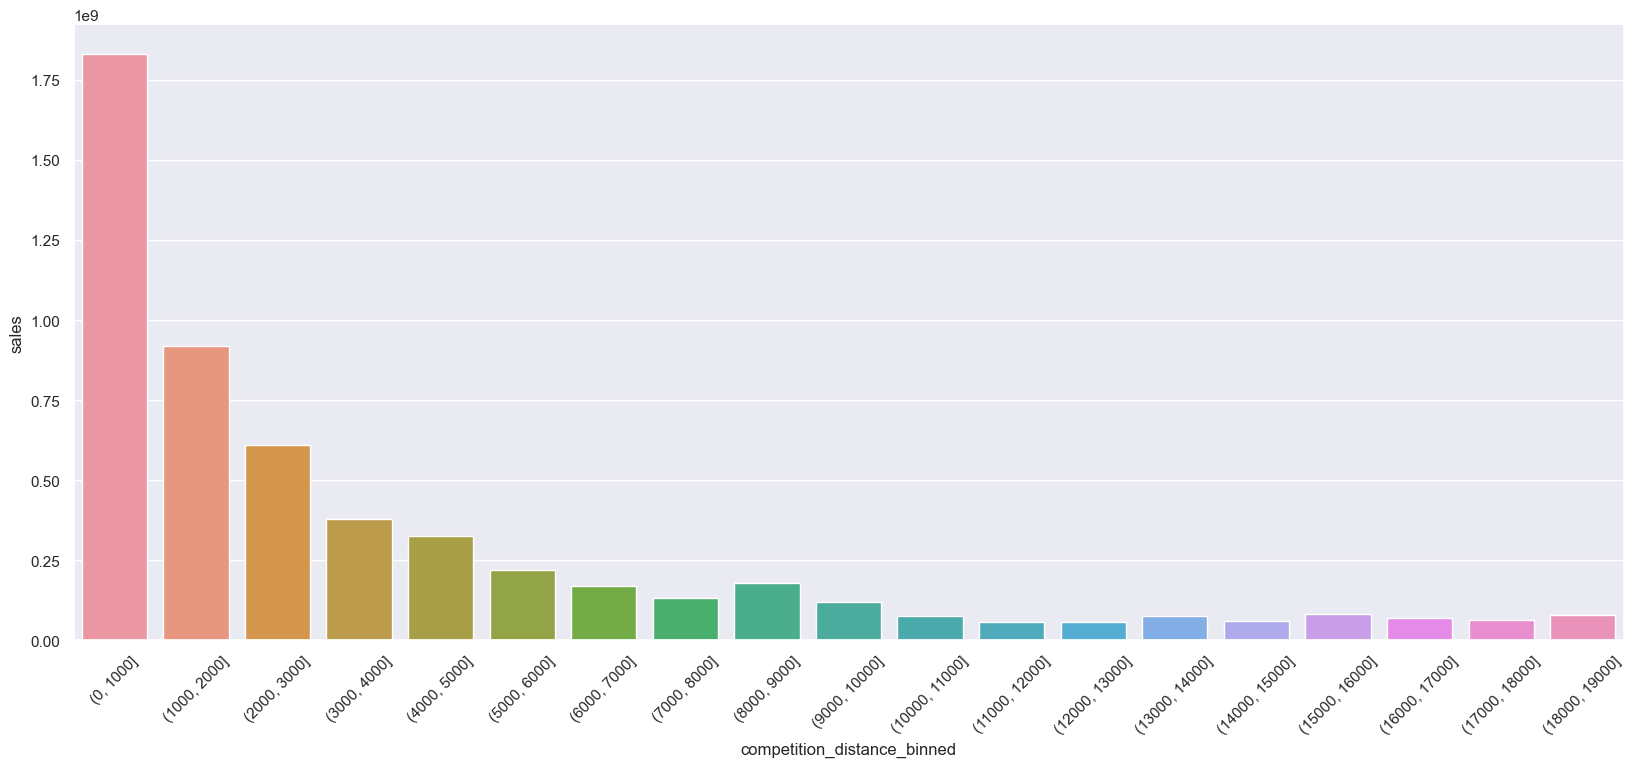

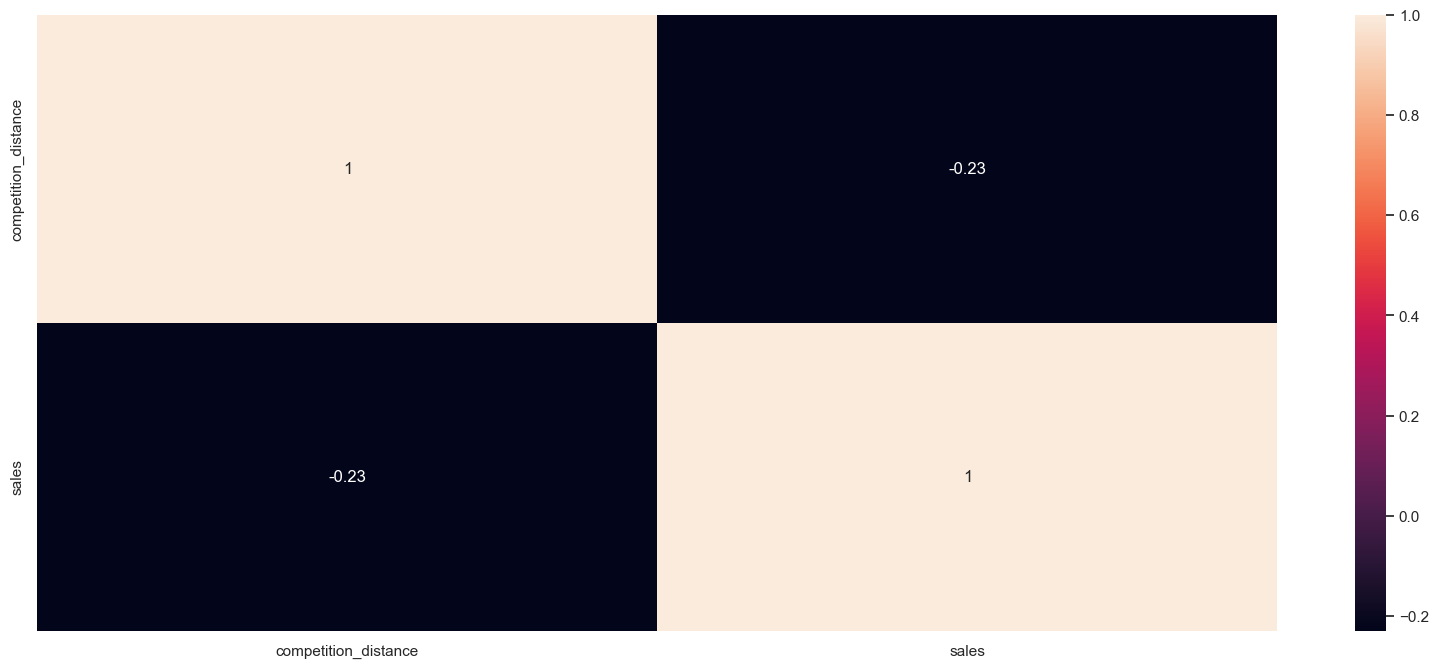

In [28]:
# Plotagem de gráficos das vendas em relação a distância da loja para os concorrentes.
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(20,8))
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.figure(figsize=(20,8))
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=45);

plt.figure(figsize=(20,8))
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Lojas com competidores a mais tempo deveriam vender mais.

*FALSA* Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

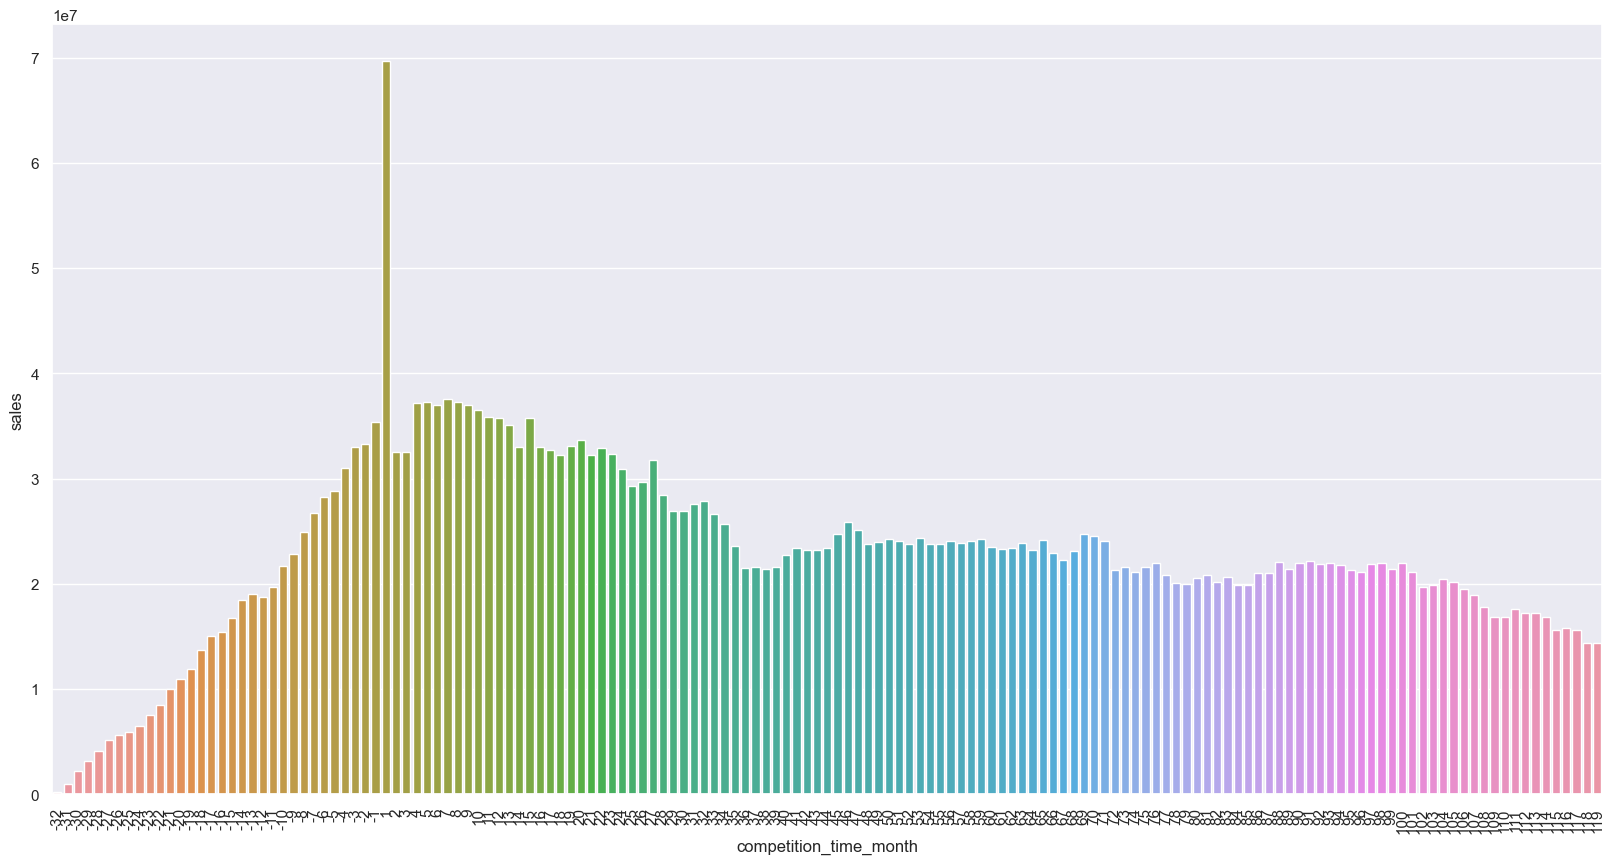

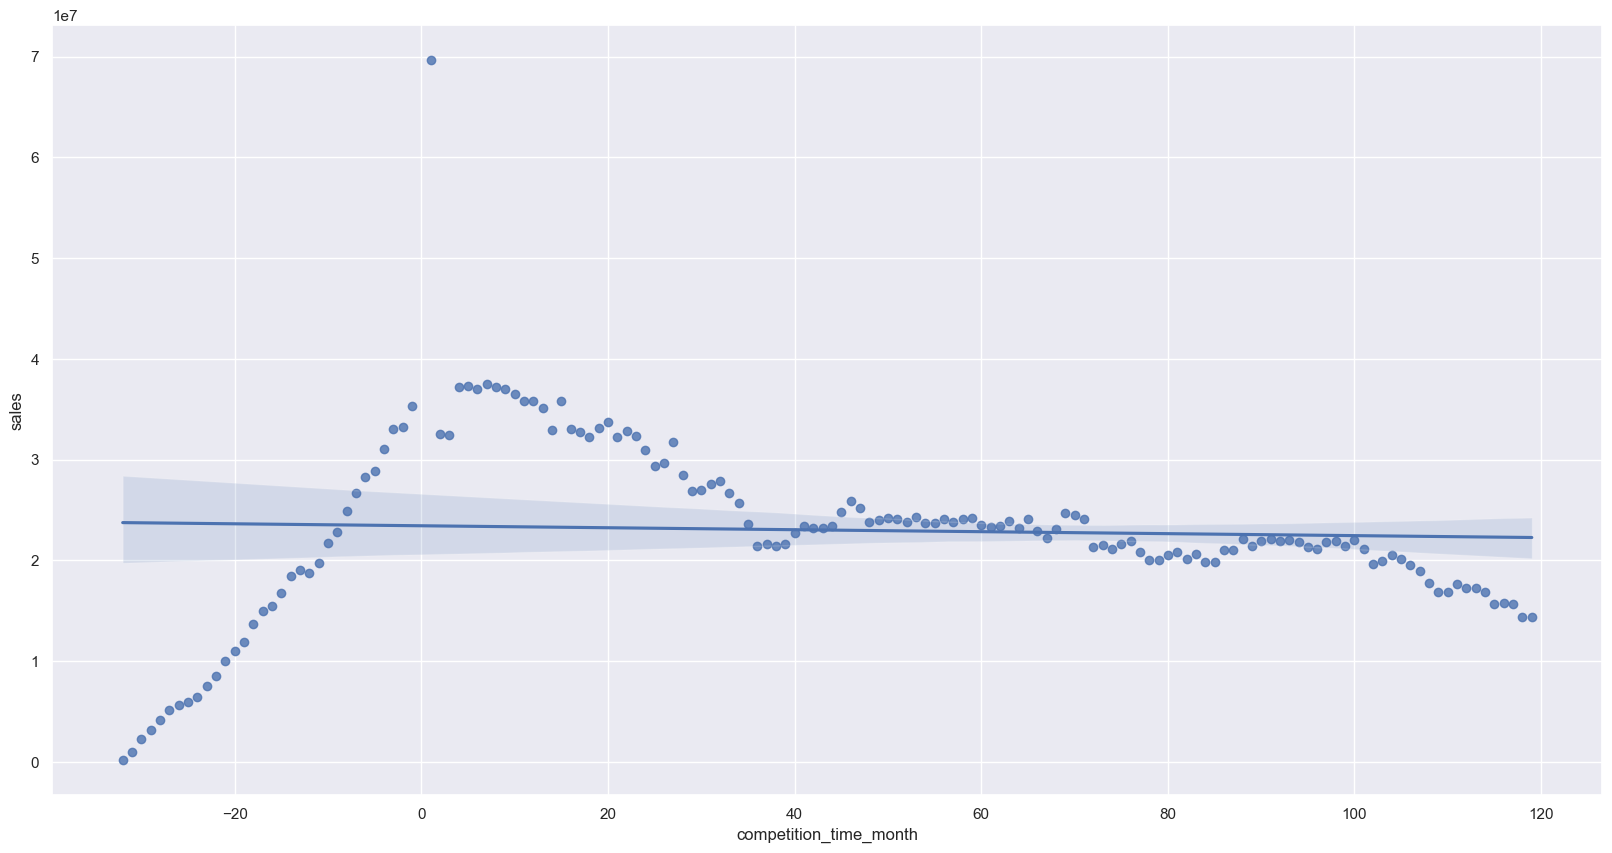

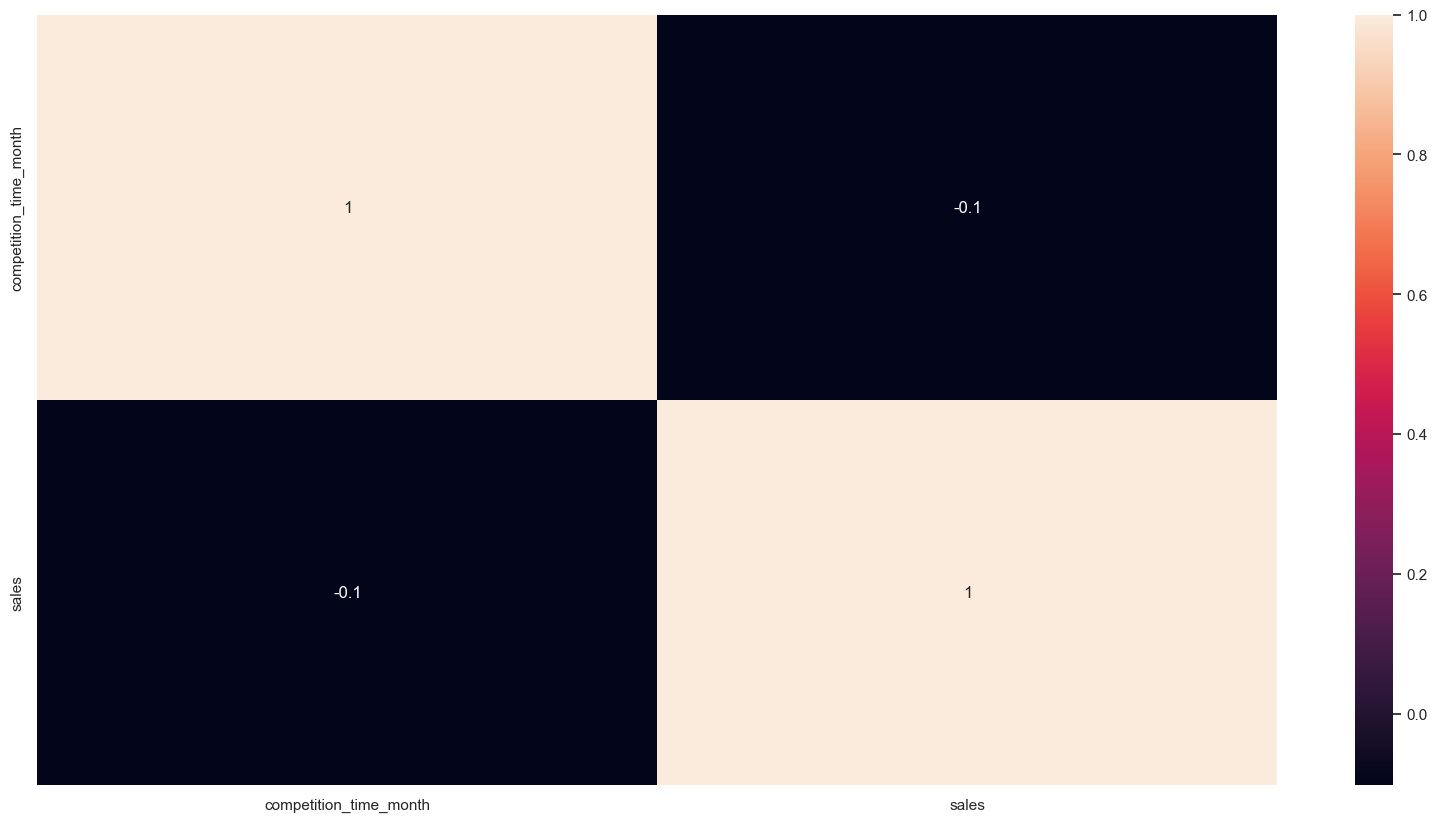

In [29]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0)]

plt.figure(figsize=(20,10));
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.figure(figsize=(20,10));
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.figure(figsize=(20,10));
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

*FALSA* Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

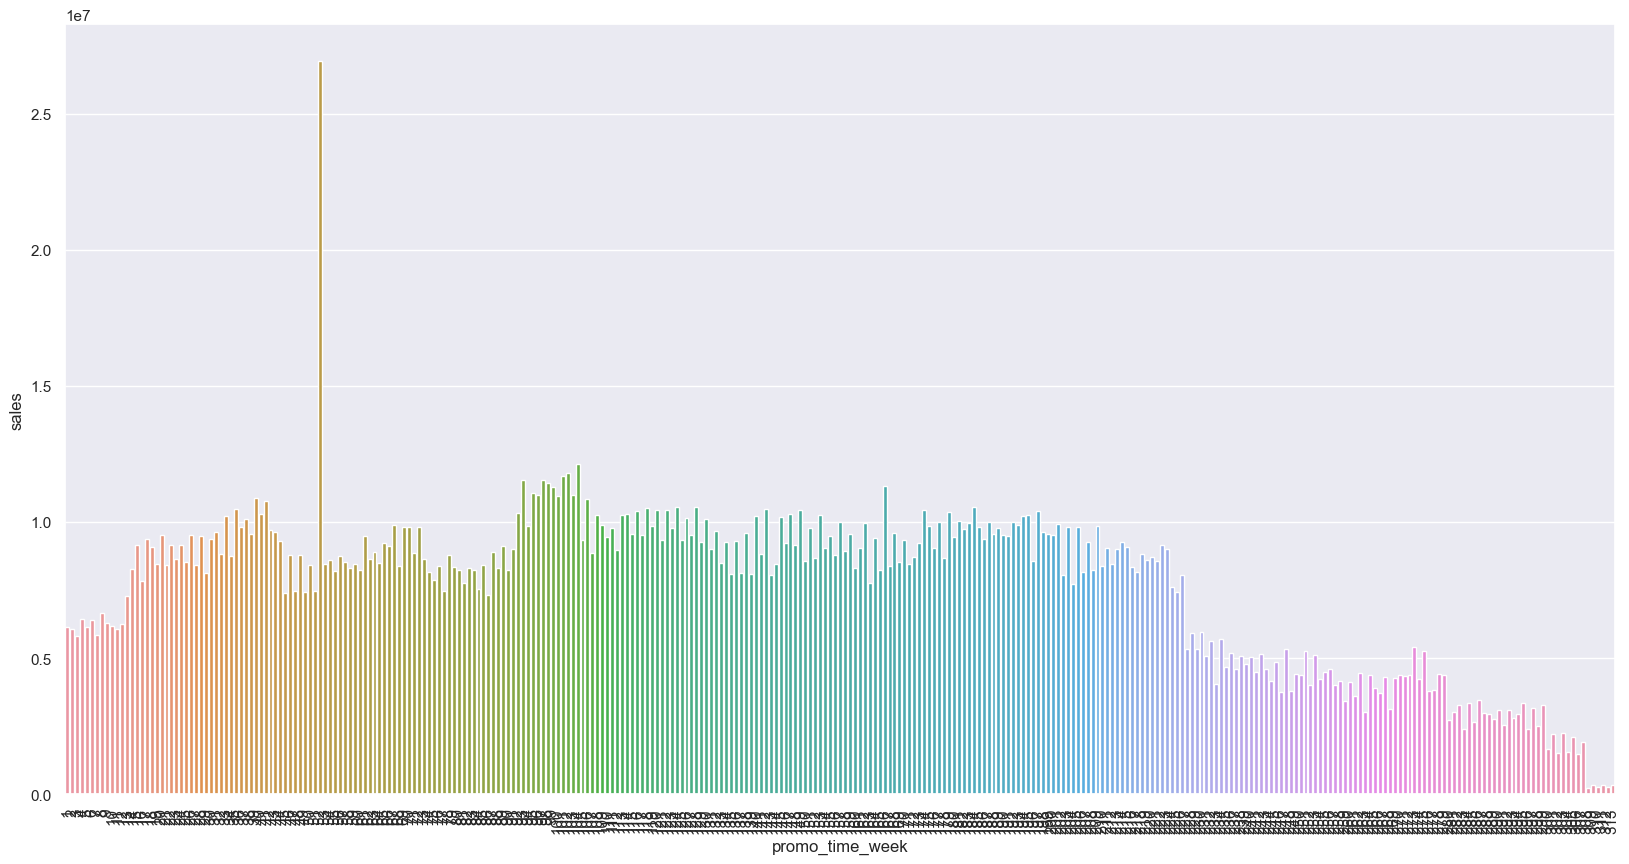

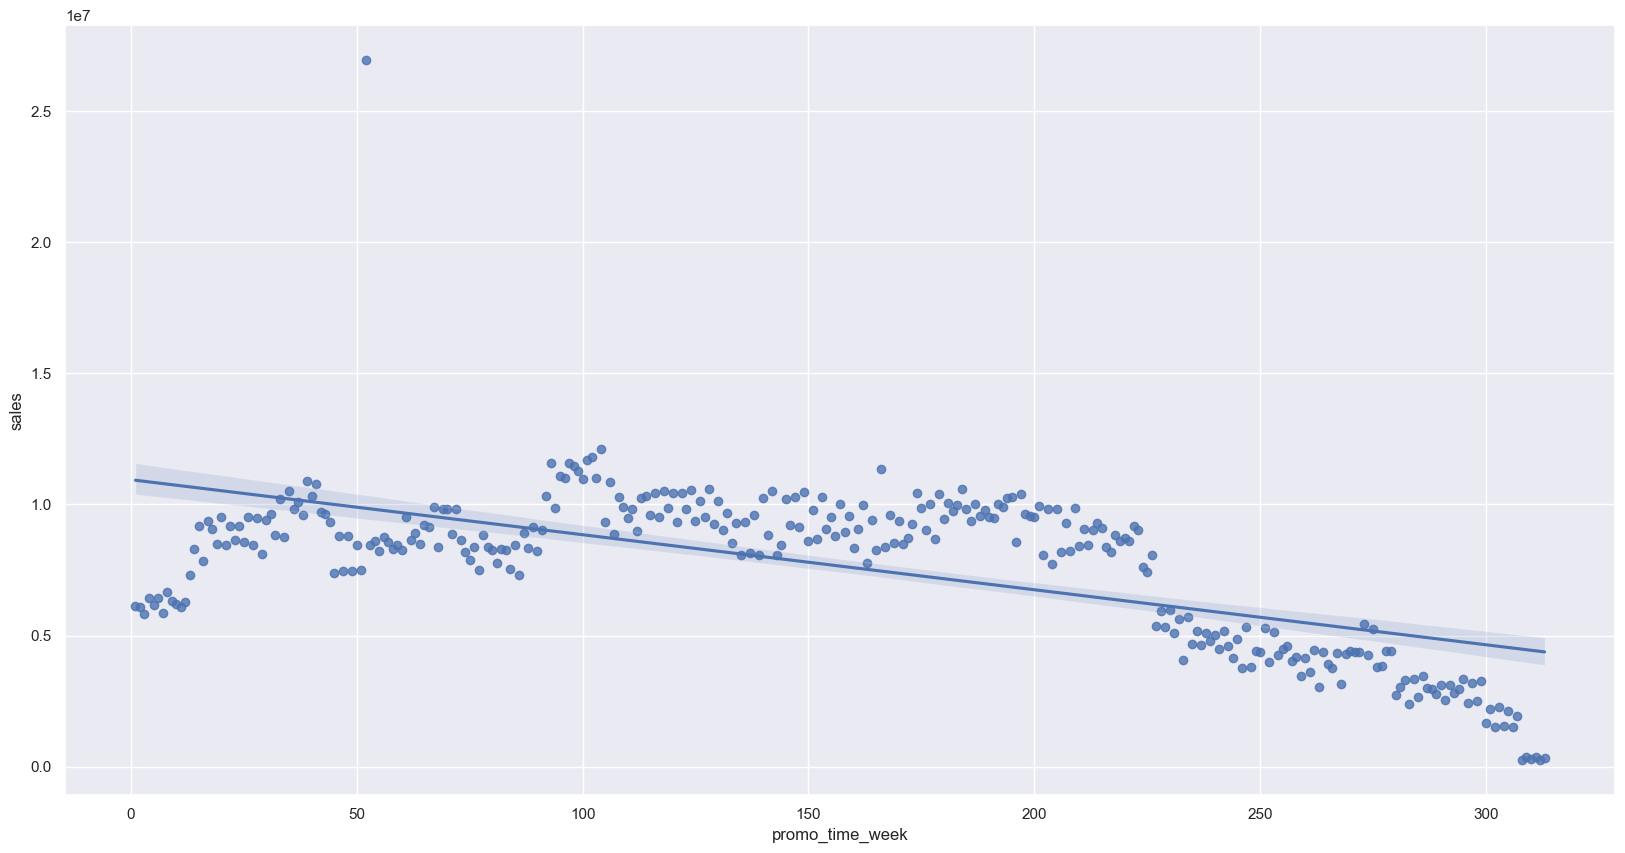

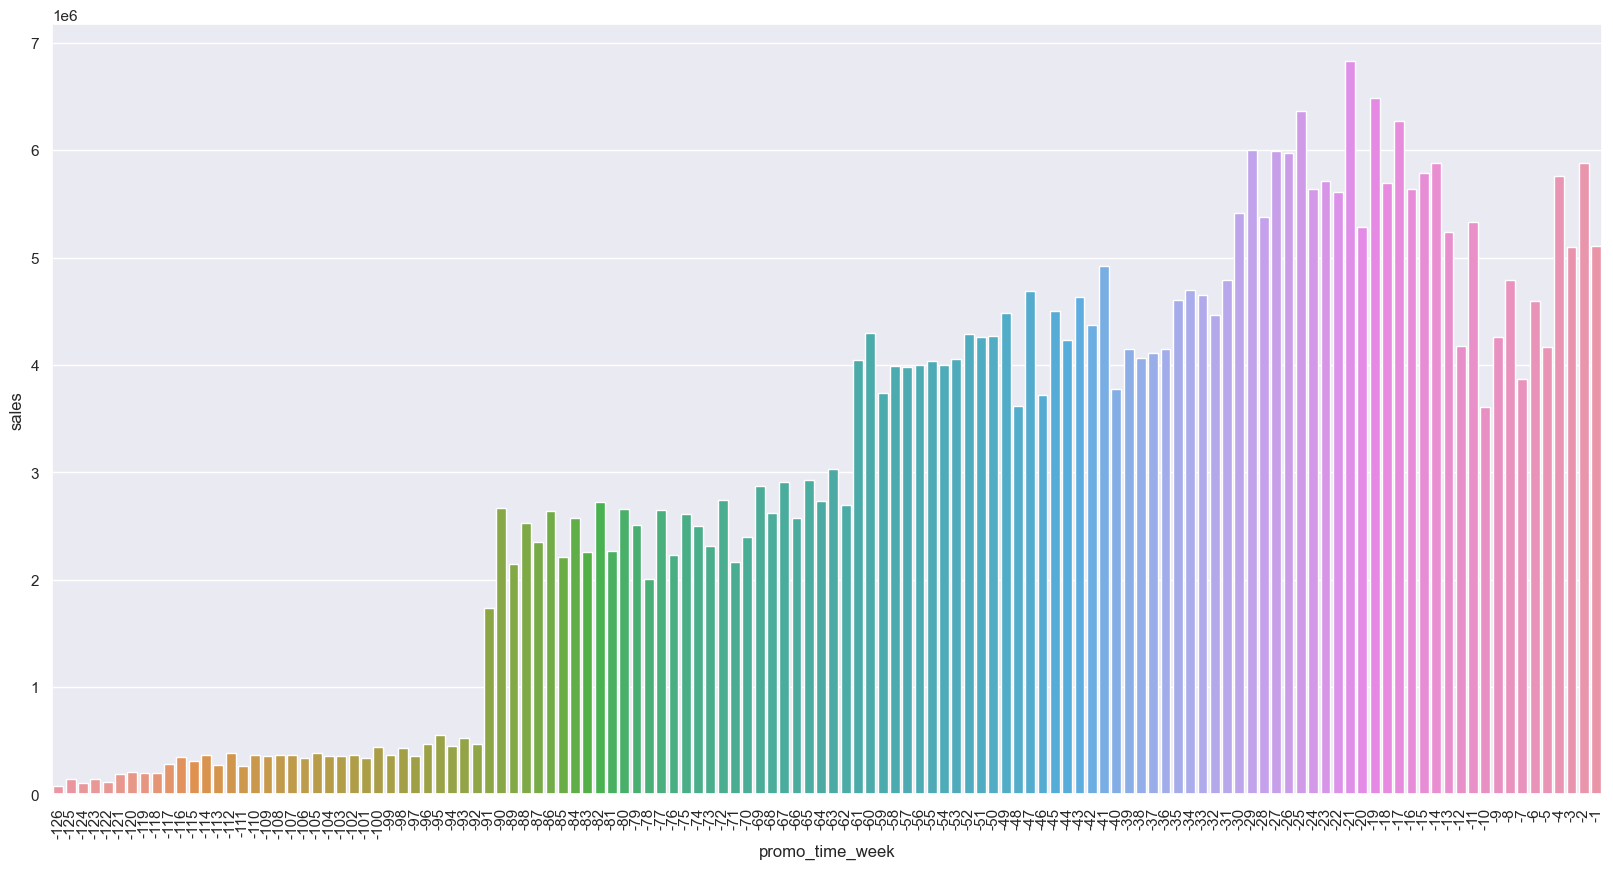

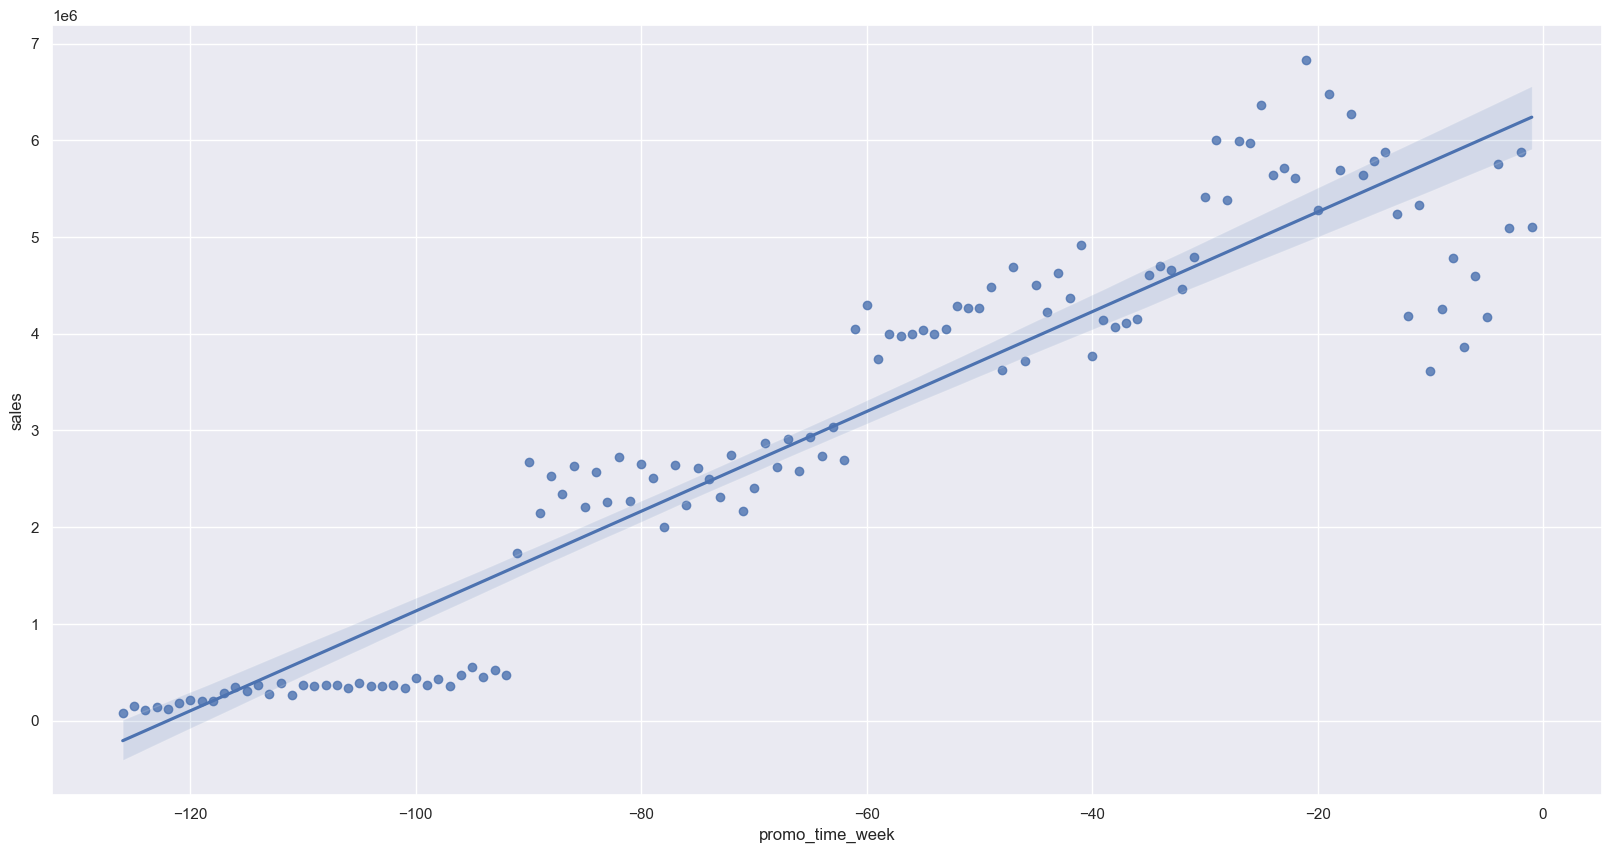

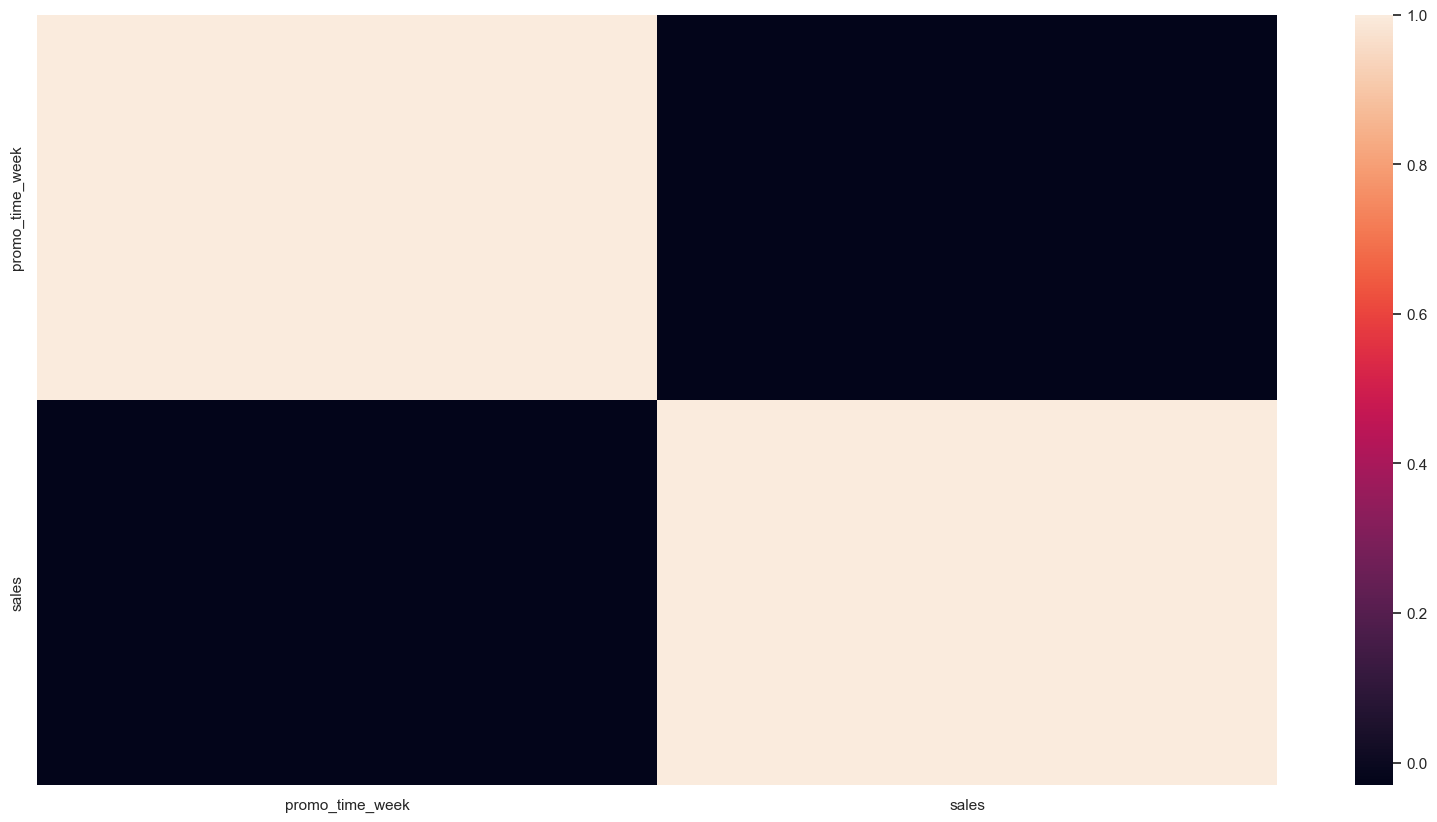

In [30]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.figure(figsize=(20,10));
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extended
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation = 90);

plt.figure(figsize=(20,10));
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.figure(figsize=(20,10));
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation = 90);

plt.figure(figsize=(20,10));
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.figure(figsize=(20,10));
sns.heatmap(aux1.corr(method='pearson'));

## H5. Lojas com mais promoções consecutivas deveriam vender mais.

*FALSA* Lojas com mais promoções consecutivas vendem menos.

In [31]:
df4[['promo', 'promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


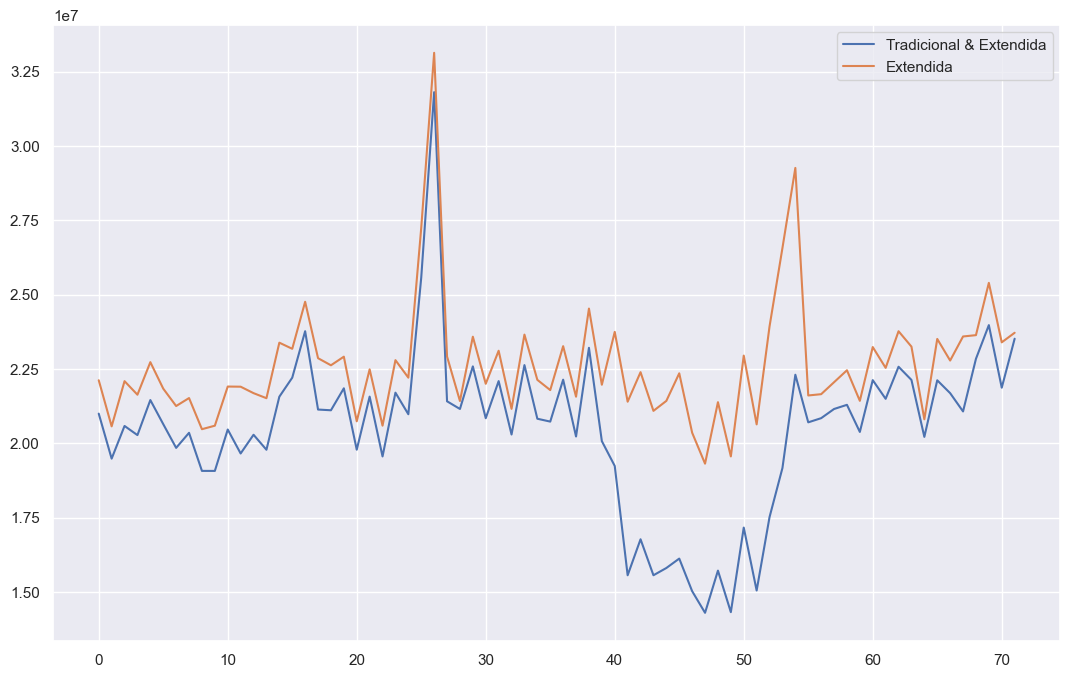

In [32]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### H6. Lojas abertas durante o feriado do Natal deveriam vender mais.

*FALSA* Lojas abertas durante o feriado do Natal vendem menos.

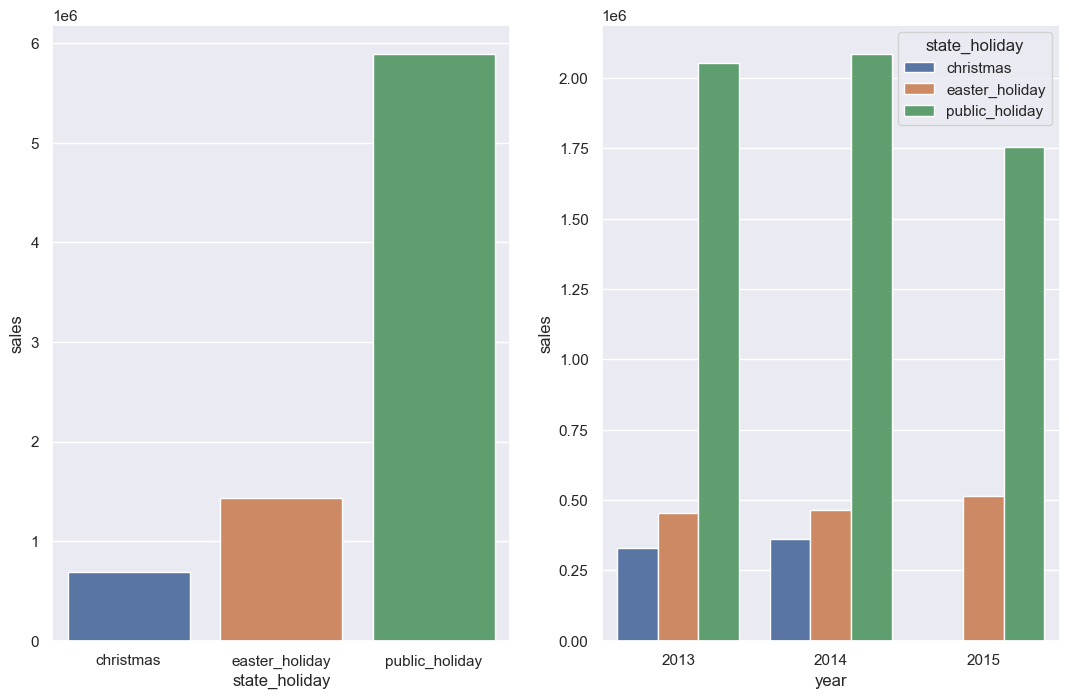

In [33]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday',y='sales',data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales', hue='state_holiday',data=aux2);

## H7. Lojas deveriam vender mais ao longo dos anos.

*FALSA* Lojas vendem menos ao longo dos anos.

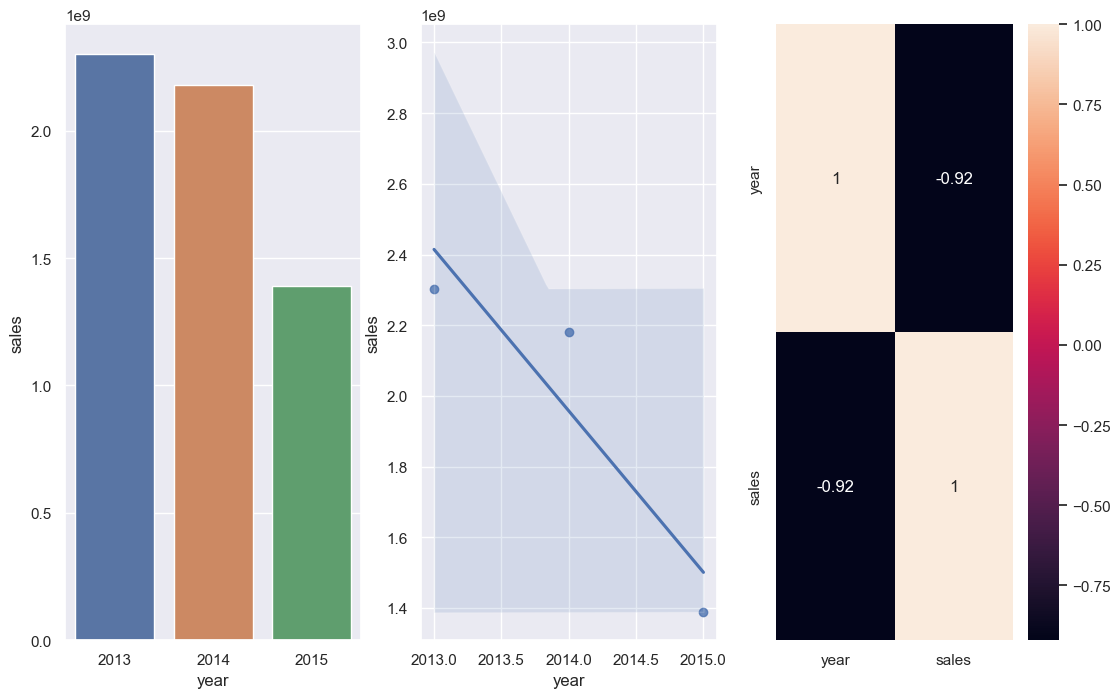

In [34]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## H8. Lojas deveriam vender mais no segundo sementre do ano.

*FALSA* Lojas vendem menos no segundo semestre do ano.

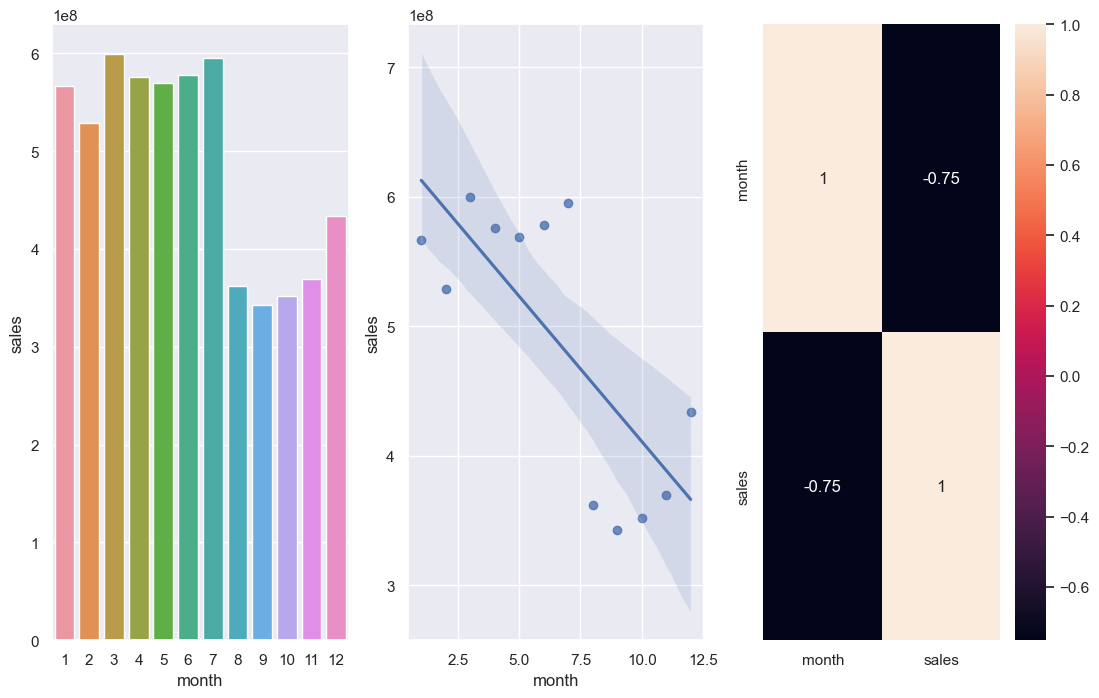

In [35]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## **H9. Lojas deveriam vender mais depois do dia 10 de cada mês.**

*VERDADEIRA* Lojas vendem mais depois do dia 10 de cada mês.

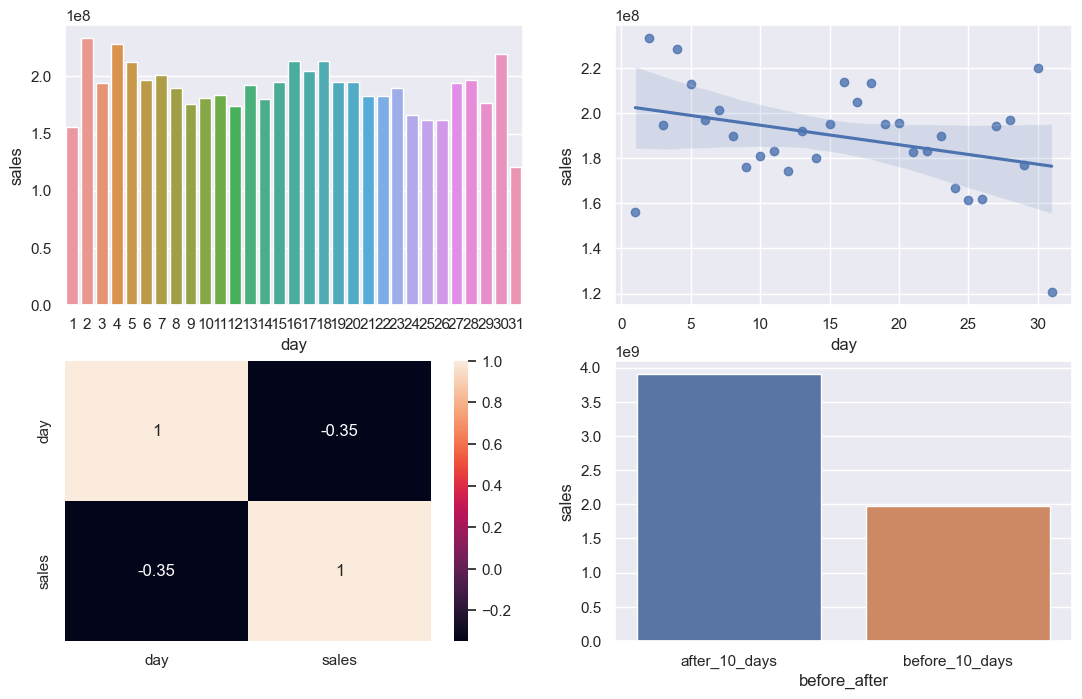

In [36]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);

### H10. Lojas deveriam vender menos aos finais de semana.

*VERDADEIRO* Lojas vendem menos nos finais de semana.

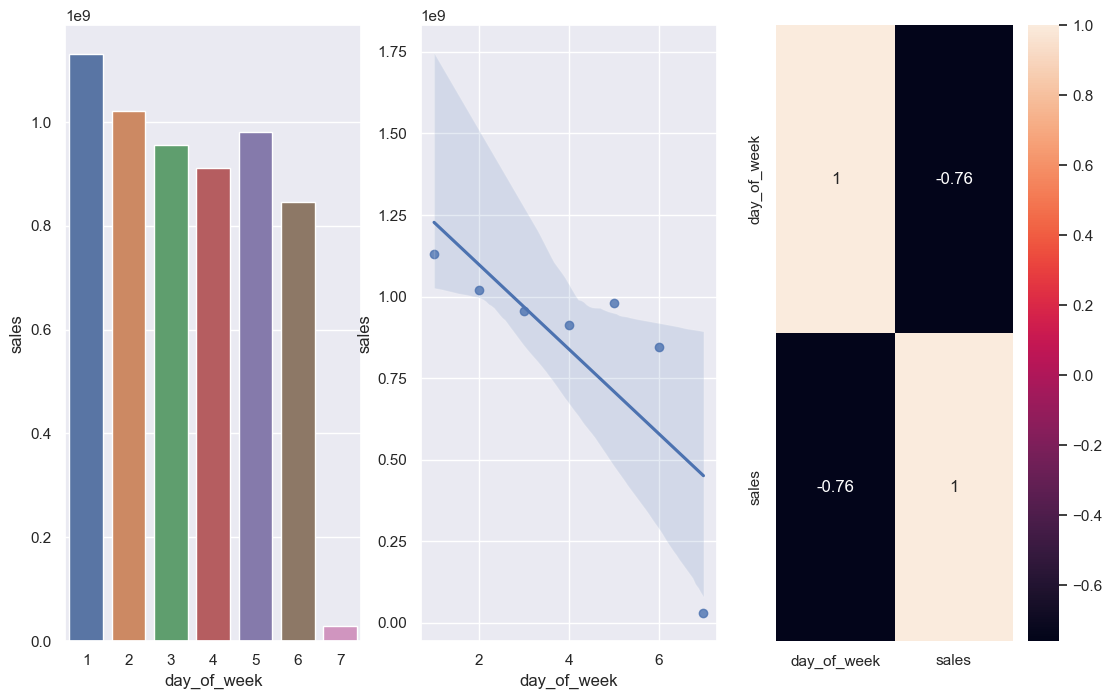

In [37]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H11. Lojas deveriam vender menos durante os feriados escolares.

*VERDADEIRA* Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

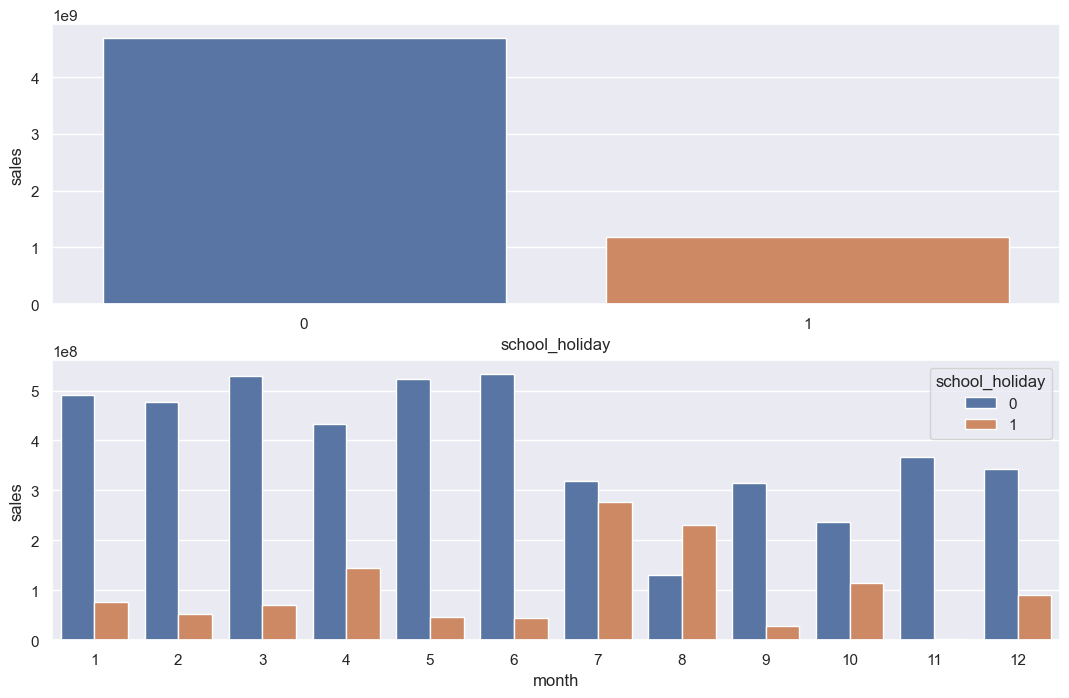

In [38]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

## Resumo das hipóteses

In [39]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
       ['H1','Verdadeira','Baixa'],
       ['H2','Falsa','Media'],
       ['H3','Falsa','Media'],
       ['H4','Falsa','Baixa'],
       ['H5','Falsa','Baixa'],
       ['H6','Falsa','Media'],
       ['H7','Falsa','Alta'],
       ['H8','Falsa','Alta'],
       ['H9','Verdadeira','Alta'],
       ['H10','Verdadeira','Alta'],
       ['H11','Verdadeira','Baixa'],
      ]
print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Verdadeira   Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           Falsa        Baixa
H6           Falsa        Media
H7           Falsa        Alta
H8           Falsa        Alta
H9           Verdadeira   Alta
H10          Verdadeira   Alta
H11          Verdadeira   Baixa


## Análise multivariada

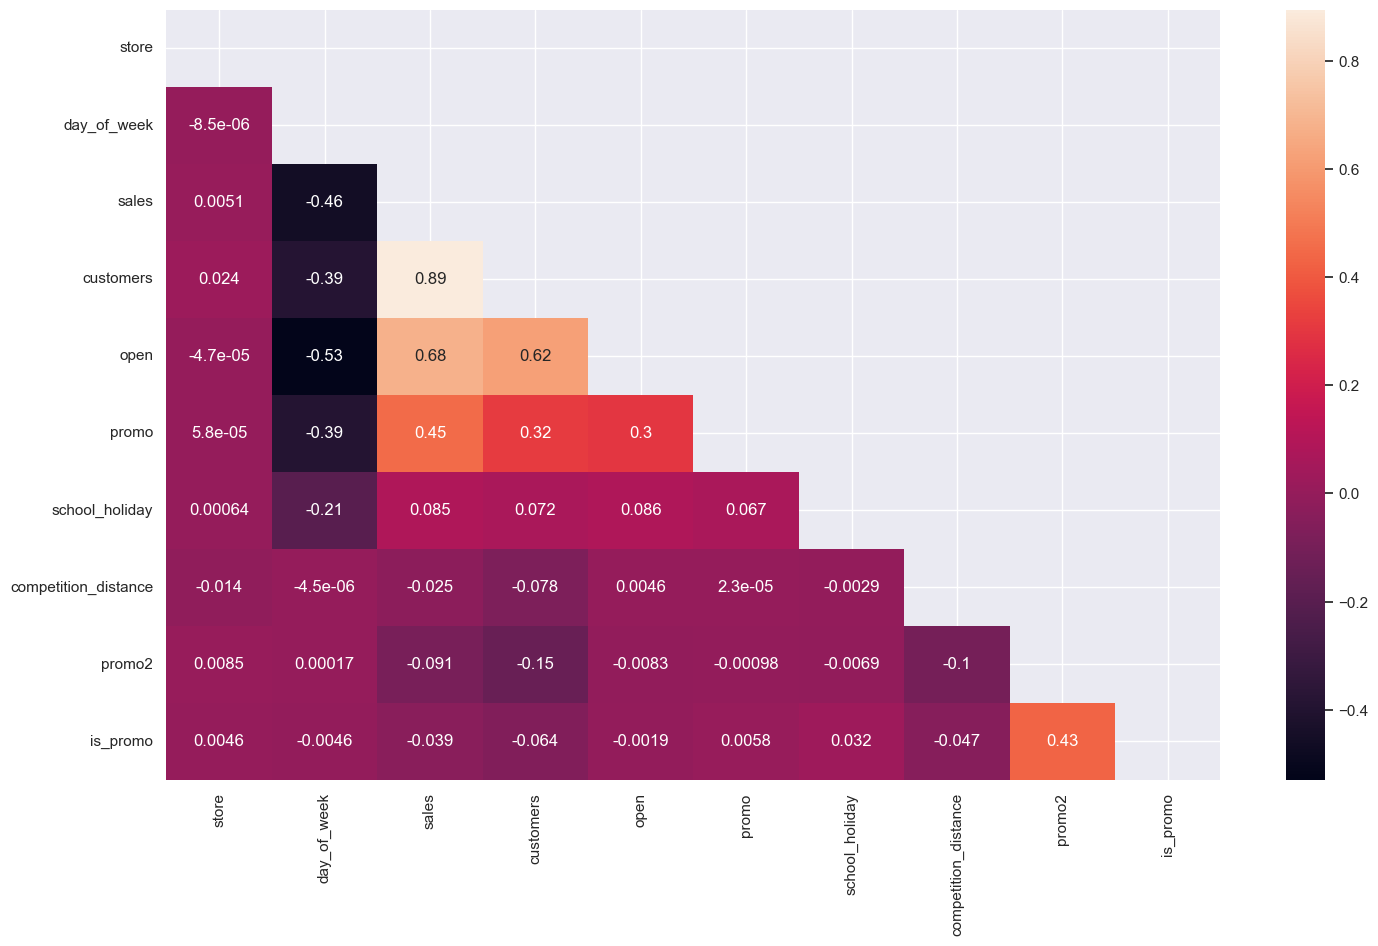

In [40]:
#Atributos Numéricos

# Mapa de correlação das variáveis. 

# Os valores de correlação são identificados como fracos, moderados ou fortes da seguinte forma:

#           Fraco ==> O valor absoluto é 0,3 ou inferior
#           Moderado ==> O valor absoluto é maior que 0,3 e menor ou igual a 0,6
#           Forte ==> O valor absoluto é maior que 0,6

correlation = num_attributes.corr(method='pearson')

plt.figure(figsize=(17,10));
matrix = np.triu(correlation)
sns.heatmap(correlation, annot=True, mask=matrix);

### **Atributos categóricos**

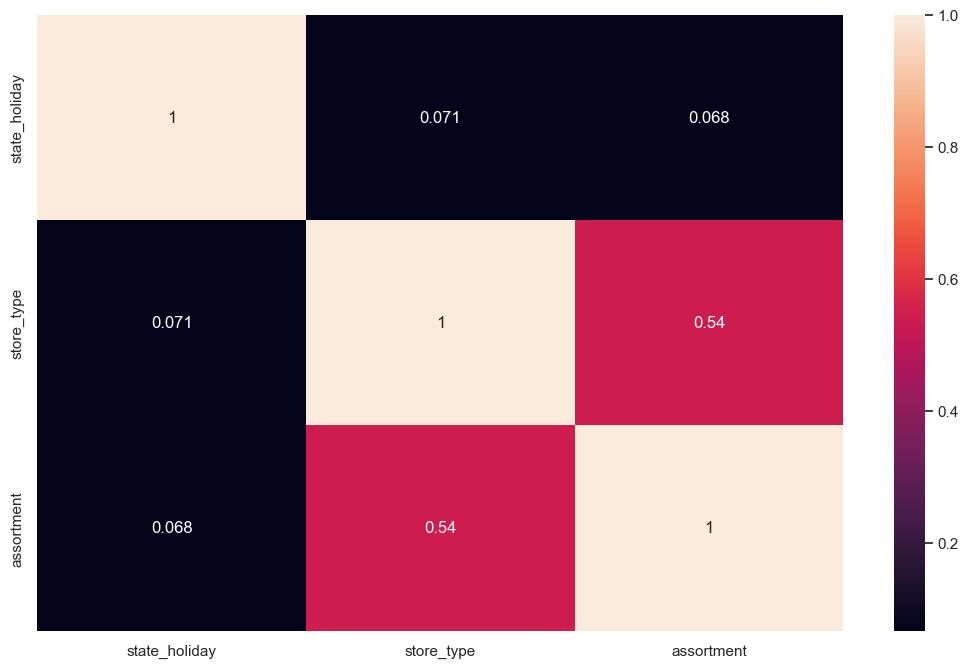

In [41]:
# Apenas dados categóricos
a = df4.select_dtypes(include='object')

# Calculando V de Cramer
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Dataset Final
d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9] })

d = d.set_index(d.columns)

sns.heatmap(d,annot=True);

# Data Preparation

In [42]:
df5 = df4.copy()

In [43]:
#redimensionando

a = df5.select_dtypes( include=['int64', 'float64'])

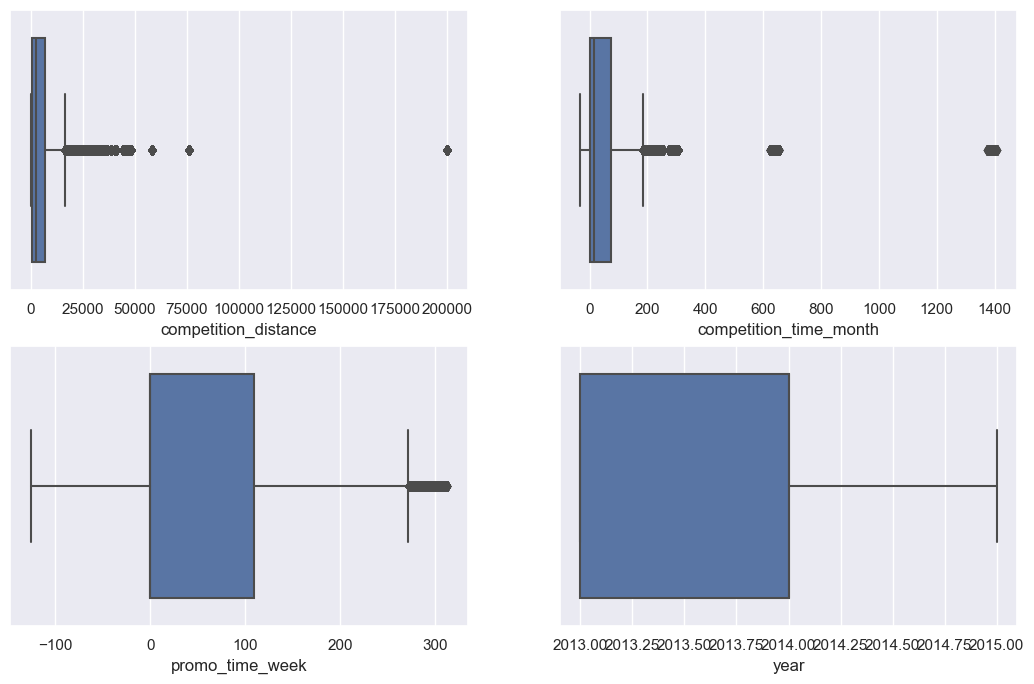

In [44]:
# Definindo quais variáveis contém valores Outliers, para utilizar o método de redimensionamento RobustScaler ou MinMaxScaler.
plt.subplot(2,2,1)
sns.boxplot(x = df5['competition_distance']);

plt.subplot(2,2,2)
sns.boxplot(x = df5['competition_time_month']);

plt.subplot(2,2,3)
sns.boxplot(x = df5['promo_time_week']);

plt.subplot(2,2,4)
sns.boxplot(x = df5['year']);

In [45]:
rs = RobustScaler() # Para poucos outliers
mms = MinMaxScaler() # Para muitos outliers

# Rescaling of competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('competition_distance_scaler.pkl', 'wb'))

# Rescaling of competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('competition_distance_scaler.pkl', 'wb'))

# Rescaling of promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('promo_time_week_scaler.pkl', 'wb'))



In [46]:
# Rescaling of year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('year_scaler.pkl', 'wb'))

### Transformação

In [47]:
#Encoding

# state holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

## Variável de resposta Transformação

In [48]:
# Transformação Logarítmica 
df5['sales'] = np.log1p(df5['sales'])

In [49]:
#Nature Transformation

#Transformação das features de Natureza cíclica
# Day of Week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x* (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x* (2. * np.pi/7)))

# Month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x* (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x* (2. * np.pi/12)))

# Day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x* (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x* (2. * np.pi/30)))

# Week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x* (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x* (2. * np.pi/52)))

## Variáveis ​​de seleção

In [50]:
df6 = df5.copy()

## Split Dataframe into training and testing dataset

In [51]:
# Deletando colunas desnecessárias
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [52]:
# As últimas 6 semanas de dados do Dataset será utilizada para teste. O restante será utilizado para treino. Abaixo temos a data limite.
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [53]:
# Separando o dataset em teste e treino de acordo com a data
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## Boruta como seletor de recursos

In [54]:
# training and test dataset for Boruta
X_train_n = X_train.drop(['date','sales'], axis=1).values
y_train_n = y_train.values.ravel()

# Define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# Define Boruta
boruta = BorutaPy (rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


## As melhores características de Boruta

In [55]:
# Armazena os índices das colunas selecionadas e ranqueadas pelo Boruta
cols_selected = boruta.support_.tolist()

# Melhores variáveis
X_train_fs = X_train.drop(['date','sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# Variáveis não selecionada pelo Boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## **Seleção manual de recursos**

In [56]:
# Selecionando manualmente as colunas que o Boruta identificou como melhores para o modelo, não necessitando rodar o boruta cada vez.
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# Adicionando Colunas
feat_to_add = ['date', 'sales']

# Final Features
cols_selected_borutal_full = cols_selected_boruta.copy()
cols_selected_borutal_full.extend(feat_to_add)

### **Modelagem de aprendizado de máquina**

In [57]:
# Criando os datasets de treino e teste com as features selecionadas pelo boruta no passo anterior.
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Preparação dos dados de série temporal
x_training = X_train[cols_selected_borutal_full]

### Average Model
Modelo Utilizado apenas para fazer a média. Neste caso, a porcentagem de erro (MAPE) foi de 20%.



In [58]:
# Criando o dataset
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Predição - Calcula a média para servir de baseline
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2,how='left', on='store')
yhat_baseline = aux1['predictions']

# Performance - Calcula as métricas de erro do modelo Average Model.
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


 ### Linear Regression Model

 A regressão linear é uma técnica de análise de dados que prevê o valor de dados desconhecidos usando outro valor de dados relacionado e conhecido. Neste caso, o modelo teve uma taxa de erro (MAPE) de 30%.

In [59]:
# Modelo
lr = LinearRegression().fit(x_train, y_train)

# Predição
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### Linear Regression Model - Cross Validation

In [60]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


### Lasso Model
Os valores dos dados encolhem para o centro ou média para evitar o sobreajustamento dos dados. Neste caso, o modelo não performou muito bem, tendo uma taxa de erro (MAPE) de 29%.

In [61]:
# Modelo
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# Predição
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


In [62]:
#  Lasso - Cross Validation

lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


### Random Forest Regressor
No algoritmo RandomForest serão criadas várias árvores de decisão, sendo este conhecimento fundamental para o entendimento do algoritmo. Neste caso, o erro (MAPE) é de aproximadamente 12%.

In [63]:
# Criando um modelo de árvore de decisão.
# n_estimators=100 ==> nº de árvores, n_jobs=-1 ==> processamento paralelo, random_state ==> seed
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# Predição
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### Random Forest Regressor - Cross Validation

In [64]:
rf_result_cv = cross_validation(x_training, 5, 'Reandom Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Reandom Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


### XGBoost Regressor
Representa uma categoria de algoritmo baseada em Decision Trees (árvores de decisão) com Gradient Boosting (aumento de gradiente). Neste caso, com erro (MAPE) foi de aproximadamente 95%.

In [65]:
# Criando o modelo XGBoost
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=100,
                             eta = 0.01,
                             max_depth = 10,
                             subsample = 0.7,
                             colsample_bytree = 0.9).fit(x_train, y_train)

# Predição
yhat_xgb = model_xgb.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.544086,0.949457,7330.812159


### XGBoost Regressor - Cross Validation

In [66]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.17 +/- 588.63,0.95 +/- 0.0,7715.17 +/- 689.51


### Compare Model's Performance

#### Single Performance

In [67]:
# Comparando as performances dos modelos
modelling_result = pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.544086,0.949457,7330.812159


### Real Performance - Cross Validation

In [68]:
# Comparando as performances reais dos modelos.
modelling_result_cv = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Reandom Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost Regressor,7049.17 +/- 588.63,0.95 +/- 0.0,7715.17 +/- 689.51


### Ajuste fino de hiperparâmetros
Embora o modelo Random Forest performou bem, tomei a decisão de seguir a diante com o modelo XGBoost, por suas características, consegue lidar eficientemente (e com robustez) com uma grande variedade de tipos diferentes de dados.

In [69]:
#Random Search

# Hiperparâmetros do modelo XGBoost com os valores que serão testados.
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15],
}

MAX_EVAL = 10

In [70]:
final_result = pd.DataFrame()

# Definindo a quantidade de iterações no teste de parâmetros.
for i in range (MAX_EVAL):
    # Escolher valores dos parâmetros aleatóriamente.
    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
    print(hp)

    # Modelo
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                                 n_estimators=hp['n_estimators'],
                                 eta = hp['eta'],
                                 max_depth = hp['max_depth'],
                                 subsample = hp['subsample'],
                                 colsample_bytree = hp['colsample_bytree'],
                                 min_child_weight = hp['min_child_weight'])

    # Performance
    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat([final_result, result])
    
final_result

{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, '

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,848.67 +/- 115.14,0.12 +/- 0.01,1224.24 +/- 170.76
0,XGBoost Regressor,859.2 +/- 117.26,0.12 +/- 0.01,1239.34 +/- 173.23
0,XGBoost Regressor,1168.43 +/- 117.19,0.16 +/- 0.01,1678.57 +/- 158.6
0,XGBoost Regressor,1512.65 +/- 157.56,0.21 +/- 0.01,2187.99 +/- 200.71
0,XGBoost Regressor,1408.93 +/- 149.13,0.2 +/- 0.01,2036.32 +/- 198.27
0,XGBoost Regressor,847.28 +/- 119.2,0.12 +/- 0.01,1221.68 +/- 174.93
0,XGBoost Regressor,1165.48 +/- 107.7,0.16 +/- 0.01,1681.24 +/- 142.51
0,XGBoost Regressor,957.17 +/- 131.86,0.13 +/- 0.01,1371.44 +/- 183.28
0,XGBoost Regressor,1669.3 +/- 178.32,0.23 +/- 0.01,2401.97 +/- 233.86
0,XGBoost Regressor,1268.28 +/- 135.53,0.18 +/- 0.01,1822.81 +/- 169.31


### Final Model

In [71]:
param_tuned = {
    'n_estimators': 3500,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.5,
    'colsample_bytree': 0.9,
    'min_child_weight': 15,
}

In [72]:
# Modelo com os melhores parâmetros
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror', 
                                   n_estimators=param_tuned['n_estimators'],
                                   eta = param_tuned['eta'],
                                   max_depth = param_tuned['max_depth'],
                                   subsample = param_tuned['subsample'],
                                   colsample_bytree = param_tuned['colsample_bytree'],
                                   min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)
# Predição
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)


# Performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,612.569682,0.088529,900.172952


## Erro de tradução e interpretação

In [73]:
df9 = X_test[cols_selected_borutal_full]

# Re-escala
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## Desempenho dos negócios

In [74]:
# Soma das Predições
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})

df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1,df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Cenários
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Ordenando Colunas
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [75]:
# Ordenando lojas com maior dificuldade de previsão.
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104274.56250,100995.333933,107553.791067,3279.228567,0.539968
908,909,243870.21875,236422.150964,251318.286536,7448.067786,0.511943
594,595,358002.59375,353375.285064,362629.902436,4627.308686,0.318187
875,876,200208.06250,196276.314973,204139.810027,3931.747527,0.289780
721,722,345517.96875,343728.185679,347307.751821,1789.783071,0.242336


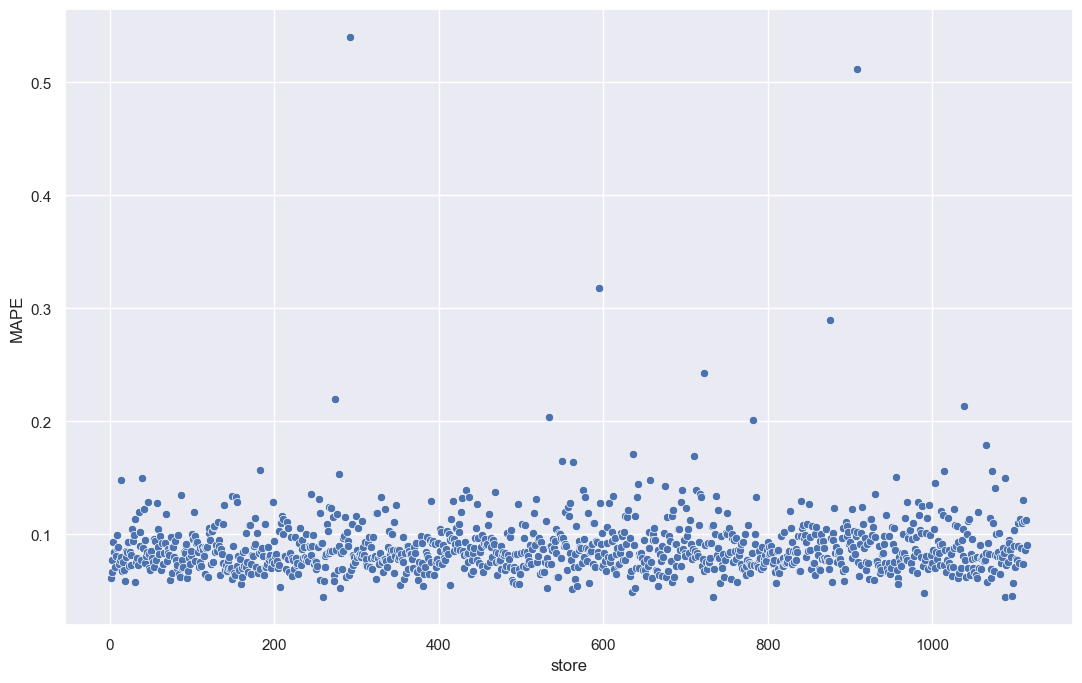

In [76]:
# Gráfico de MAPE por loja.
sns.scatterplot(x='store', y='MAPE', data=df92);

## Total Performance

In [77]:
# Performance total para as próximas 6 semanas
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$283,588,352.00"
1,worst_scenario,"R$282,901,138.01"
2,best_scenario,"R$284,275,526.30"


## Machine Learning Performance

In [78]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

C:\Users\Estúdio\AppData\Local\Temp\ipykernel_81404\1456458654.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df9['error']);


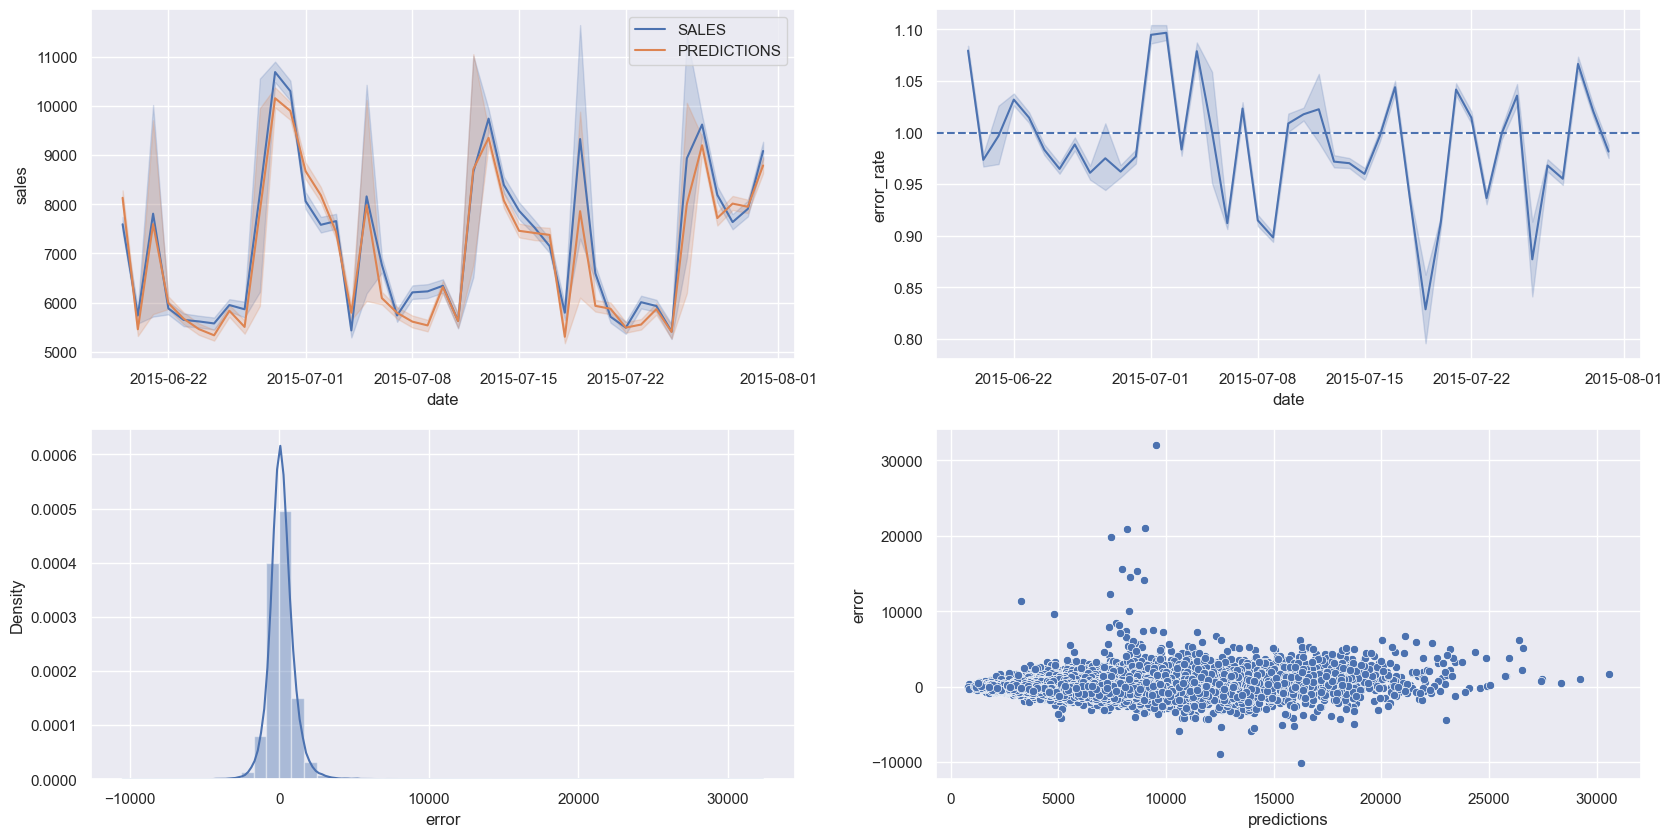

In [79]:
plt.figure(figsize=(20,10));
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES');
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS');

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9);
plt.axhline(1, linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error']);

plt.subplot(2,2,4)
sns.scatterplot(x=df9['predictions'], y=df9['error']);

## Deploy do modelo em produção

In [80]:
# Modelo treinado Salvo
pickle.dump(model_xgb_tuned, open('/Users/Estúdio/Music/projeto/model_rossmann.pkl', 'wb'))

## Classe Rossmann

In [81]:
class Rossmann ( object ):
    def __init__(self):
        self.competiotion_distance_scaler = pickle.load(open('parameter/competition_distance_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load(open('parameter/promo_time_week_scaler.pkl', 'rb'))
        self.competiotion_time_month_scaler = pickle.load(open('parameter/competition_time_month_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open('parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open('parameter/store_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):

        ## 1.1. Renomeando Colunas

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        # Rename
        df1.columns = cols_new

        ## 1.3. Tipos dos Dados

        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5. Preenchendo valores NA

        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        #promo2_since_year    
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        #promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


        ## 1.6. Mudando tipos de Dados

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1

    def feature_engineering (self, df2):
    
        # Year
        df2['year'] = df2['date'].dt.year

        # Month
        df2['month'] = df2['date'].dt.month

        # Day
        df2['day'] = df2['date'].dt.day

        # Week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # Year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # Competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply (lambda x: x.days).astype(int)

        # Promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w')-datetime.timedelta(days=7))

        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # Assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # State holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0. - Filtrando Variáveis
        ## 3.1. Filtrando Linhas

        df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]

        ## 3.2. Filtrando Colunas

        cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    def data_preparation (self, df5):

        # competition distance
        df5['competition_distance'] = self.competiotion_distance_scaler.transform(df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.transform(df5[['year']].values)

        ### 5.2.1 Encoding

        # state holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'])
        

        # assortment - Ordinal Encoding
        assortment_dict = {'basic':1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.2.3 Transformação da Natureza

        # Day of Week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x* (2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x* (2. * np.pi/7)))

        # Month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x* (2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x* (2. * np.pi/12)))

        # Day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x* (2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x* (2. * np.pi/30)))

        # Week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x* (2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x* (2. * np.pi/52)))
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance','competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']

        
        return df5[cols_selected]

## Manipulador de API

In [82]:
#from rossmann.Rossmann     import Rossmann

# Loadin Model
model = pickle.load (open('/Users/Estúdio/Music/projeto/model_rossmann.pkl', 'rb'))

# Initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json, dict): # Unique Example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # Multiple Examples  
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # Data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # Feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # Data preparation
        df3 = pipeline.data_preparation(df2)
        
        # Prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.117:5000
Press CTRL+C to quit


## Teste da API

In [84]:
# Carregando test dataset
df10 = pd.read_csv('Data/test.csv')

In [85]:
# Merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# Choose store for prediction
df_test = df_test[df_test['Store'].isin([4, 17, 25, 30, 47, 51, 66, 74])]

# Remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [86]:
# Convert Dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [ ]:
# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://prediction-sales-project.herokuapp.com/rossmann/predict'
header = {'Content-type' : 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'. format(r.status_code))

In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [ ]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range (len(d2)):
    print('A Loja Número {} venderá R${:,.2f} nas próximas 6 semanas.'.format(
            d2.loc[i,'store'],
            d2.loc[i,'prediction']))